<a href="https://www.kaggle.com/code/ndannnop/computer-vision?scriptVersionId=240659003" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!pip install pybcf pysam keras-layer-normalization

In [1]:
# import libraries
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import os
import random
import math # Needed for ceiling division
    
class BCFImagePatchDataset(Dataset):
    """
    PyTorch Dataset for loading either images from a BCF file or from a folder of JPEG files,
    and extracting patches on the fly. Loads images as grayscale.
    """
    def __init__(self, data_source, label_file=None, num_patch=3, patch_size=(105, 105)):
        """
        Initializes the dataset. Can handle both BCF files and JPEG images.

        Args:
            data_source (str): Path to the BCF file or directory containing JPEG images.
            label_file (str): Path to the label file (required only for BCF files).
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): (height, width) of patches.
        """
        self.data_source = data_source
        self.label_file = label_file
        self.num_patch = num_patch
        self.patch_size = patch_size

        self.labels = None
        self.image_filenames = []

        # Determine whether the dataset is based on BCF or JPEG files
        if data_source.endswith('.bcf'):
            self._read_bcf_metadata()
        else:
            self._read_image_filenames()

    def _read_bcf_metadata(self):
        """Reads labels and image size/offset information from BCF files."""
        try:
            # Read label file
            if not self.label_file:
                raise ValueError("Label file is required for BCF data source.")
            with open(self.label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Read {len(self.labels)} labels.")

            # Read BCF header
            with open(self.data_source, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"BCF header indicates {self.num_images} images.")

                if len(self.labels) != self.num_images:
                    raise ValueError(f"Mismatch between number of labels ({len(self.labels)}) and images in BCF header ({self.num_images}).")

                # Read all image sizes
                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)
                print(f"Read {len(self.image_sizes)} image sizes.")

                # Calculate the starting offset of the actual image data blob
                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])
                print("Calculated image offsets.")

        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
            raise
        except Exception as e:
            print(f"Error reading metadata: {e}")
            raise

    def _read_image_filenames(self):
        """Reads image filenames from a folder (only for JPEG images)."""
        try:
            # List all JPEG images in the folder
            self.image_filenames = [f for f in os.listdir(self.data_source) if f.endswith('.jpeg') or f.endswith('.jpg')]
            print(f"Found {len(self.image_filenames)} JPEG images.")

            if len(self.image_filenames) == 0:
                raise ValueError("No JPEG images found in the specified folder.")
        except FileNotFoundError as e:
            print(f"Error: Folder not found - {e}")
            raise
        except Exception as e:
            print(f"Error reading filenames: {e}")
            raise

    def __len__(self):
        """Returns the total number of images in the dataset."""
        if hasattr(self, 'num_images'):
            return self.num_images  # For BCF files
        return len(self.image_filenames)  # For JPEG images

    def __getitem__(self, idx):
        """
        Loads one image as grayscale, extracts patches, and returns patches with the label.
    
        Args:
            idx (int): The index of the image to retrieve.
    
        Returns:
            tuple: (list[np.ndarray], int): A tuple containing:
                     - A list of NumPy arrays, each representing a patch (H, W).
                     - The integer label for the image (or 0 for JPEG).
                   Returns ([], -1) if image reading or patch extraction fails.
        """
        if hasattr(self, 'num_images'):  # BCF source
            if idx >= self.num_images or idx < 0:
                raise IndexError(f"Index {idx} out of bounds for {self.num_images} images.")
    
            label = self.labels[idx]
            offset = self.image_offsets[idx]
            size = self.image_sizes[idx]
    
            try:
                with open(self.data_source, 'rb') as f:
                    f.seek(self.data_start_offset + offset)
                    image_bytes = f.read(size)
    
                img = Image.open(BytesIO(image_bytes)).convert('L')
                img_array = np.array(img)
                patches = extract_patches(img_array, self.num_patch, self.patch_size)
    
                return patches, label
    
            except Exception as e:
                print(f"Error processing image index {idx}: {e}")
                return [], -1  # Indicate error
    
        else:  # JPEG source
            if idx >= len(self.image_filenames) or idx < 0:
                raise IndexError(f"Index {idx} out of bounds for {len(self.image_filenames)} images.")
    
            image_filename = self.image_filenames[idx]
            image_path = os.path.join(self.data_source, image_filename)
    
            try:
                img = Image.open(image_path).convert('L')
                img_array = np.array(img)
                patches = extract_patches(img_array, self.num_patch, self.patch_size)
    
                return patches, 0
    
            except Exception as e:
                print(f"Error processing image index {idx}: {e}")
                return [], -1  # Indicate error

def patch_collate_fn(batch, patch_size_tuple):
    """
    Collates data from the BCFImagePatchDataset (handling grayscale) or JPEG-based dataset.

    Takes a batch of [(patches_list_img1, label1), (patches_list_img2, label2), ...],
    flattens the patches, converts them to a tensor, adds a channel dimension,
    normalizes, and returns a single batch tensor for patches and labels.

    Args:
        batch (list): A list of tuples, where each tuple is the output
                      of BCFImagePatchDataset.__getitem__.
        patch_size_tuple (tuple): The (height, width) of patches, needed for empty tensor shape.

    Returns:
        tuple: (torch.Tensor, torch.Tensor): A tuple containing:
                 - Patches tensor (BatchSize * NumPatches, 1, Height, Width)
                 - Labels tensor (BatchSize * NumPatches)
    """
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    for item in batch:
        patches, label = item
        # Ensure item is valid (e.g., image wasn't too small, no read errors)
        if patches and label != -1:
            # Only add patches if the list is not empty
            all_patches.extend(patches)
            # Repeat the label for each patch extracted from the image
            all_labels.extend([label] * len(patches))
            valid_batch_items += 1

    # If no valid patches were collected in the batch (e.g., all images too small)
    if not all_patches:
        # Return empty tensors of appropriate type but 0 size in the batch dimension
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Convert list of NumPy arrays (each H, W) to a single NumPy array
    patches_np = np.array(all_patches)  # Shape: (TotalPatches, H, W)

    # Convert to PyTorch tensor, normalize
    patches_tensor = torch.tensor(patches_np).float() / 255.0  # Shape: (TotalPatches, H, W)

    # Add channel dimension: (TotalPatches, H, W) -> (TotalPatches, 1, H, W)
    patches_tensor = patches_tensor.unsqueeze(1)

    # Convert labels to PyTorch tensor
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # Use long for classification labels

    return patches_tensor, labels_tensor

In [2]:
import easyocr
import numpy as np
import os
import tempfile
from PIL import Image

# Global OCR reader for efficiency
_ocr_reader = None

def get_ocr_reader(languages=["en"]):
    global _ocr_reader
    if _ocr_reader is None:
        _ocr_reader = easyocr.Reader(languages)
    return _ocr_reader

def extract_patches(image_array, num_patch=3, patch_size=(105, 105), 
                    extract_text=True, min_text_coverage=0.3, max_attempts=20):
    patch_h, patch_w = patch_size

    # Determine if grayscale or color
    if image_array.ndim == 2:
        h, w = image_array.shape
        is_grayscale = True
    elif image_array.ndim == 3:
        h, w, _ = image_array.shape
        is_grayscale = False
    else:
        print(f"Unexpected image shape: {image_array.shape}")
        return []

    # === Step 1: Resize image to height = 105, maintain aspect ratio ===
    scale_factor = patch_h / h
    new_w = int(w * scale_factor)
    if is_grayscale:
        resized = cv2.resize(image_array, (new_w, patch_h), interpolation=cv2.INTER_LINEAR)
    else:
        resized = cv2.resize(image_array, (new_w, patch_h), interpolation=cv2.INTER_LINEAR)

    # === Step 2: Check if width is enough for patch ===
    if new_w < patch_w:
        return []

    # === Step 3: If not extracting text, return random crops ===
    if not extract_text:
        patches = []
        for _ in range(num_patch):
            x = np.random.randint(0, new_w - patch_w + 1)
            if is_grayscale:
                patch = resized[:, x:x + patch_w]
            else:
                patch = resized[:, x:x + patch_w, :]
            patches.append(patch)
        return patches

    # === Step 4: Try to find text patches using OCR ===
    reader = get_ocr_reader()
    text_patches = []
    attempts = 0

    while len(text_patches) < num_patch and attempts < max_attempts:
        x = np.random.randint(0, new_w - patch_w + 1)
        if is_grayscale:
            patch = resized[:, x:x + patch_w]
        else:
            patch = resized[:, x:x + patch_w, :]

        # Save patch to temporary file for OCR
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
            tmp_path = tmp.name
            patch_img = Image.fromarray(patch)
            patch_img.save(tmp_path)

        try:
            ocr_results = reader.readtext(tmp_path)
            os.unlink(tmp_path)

            patch_area = patch_h * patch_w
            text_area = 0
            for bbox, text, conf in ocr_results:
                if conf < 0.5:
                    continue
                bbox = [[int(p[0]), int(p[1])] for p in bbox]
                min_x = max(0, min(p[0] for p in bbox))
                max_x = min(patch_w, max(p[0] for p in bbox))
                min_y = max(0, min(p[1] for p in bbox))
                max_y = min(patch_h, max(p[1] for p in bbox))
                if max_x > min_x and max_y > min_y:
                    text_area += (max_x - min_x) * (max_y - min_y)

            if text_area / patch_area >= min_text_coverage:
                text_patches.append(patch)

        except Exception as e:
            print(f"OCR error: {e}")
            try:
                os.unlink(tmp_path)
            except:
                pass

        attempts += 1

    return text_patches



In [75]:
# augmentation functions
import random
import numpy as np
import cv2
from PIL import Image, ImageFilter

TARGET_SIZE = (105, 105)

def to_uint8(img: np.ndarray) -> np.ndarray:
    return np.clip(img, 0, 255).astype(np.uint8)

def noise_image(img: np.ndarray, mean=0.0, std=3.0) -> np.ndarray:
    """Add Gaussian noise."""
    f = img.astype(np.float32)
    n = np.random.normal(mean, std, f.shape).astype(np.float32)
    return to_uint8(f + n)

def blur_image(img: np.ndarray, sigma_range=(0.5, 1.5)) -> np.ndarray:
    """
    Apply a mild, randomly‐parameterized Gaussian blur.
    
    Args:
        img (np.ndarray): Input image, either H×W or H×W×C, dtype uint8.
        sigma_range (tuple): Min/max sigma for the blur kernel.
    
    Returns:
        np.ndarray: Blurred image, same shape and dtype uint8.
    """
    # Ensure float for convolution
    f = img.astype(np.float32)
    # Randomize sigma in the given range
    sigma = random.uniform(*sigma_range)
    # OpenCV: kernel size (0,0) triggers automatic size based on sigma
    if f.ndim == 2:
        blurred = cv2.GaussianBlur(f, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
    else:
        # Split channels and blur each independently
        channels = cv2.split(f)
        channels = [cv2.GaussianBlur(ch, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
                    for ch in channels]
        blurred = cv2.merge(channels)
    # Restore uint8
    return np.clip(blurred, 0, 255).astype(np.uint8)

def affine_rotation(img: np.ndarray, max_deg=10) -> np.ndarray:
    """Small random affine warp."""
    h, w = img.shape[:2]
    # random shift on three points
    src = np.float32([[0,0],[w-1,0],[0,h-1]])
    dx = w * 0.05
    dy = h * 0.05
    dst = src + np.random.uniform([-dx, -dy], [dx, dy], src.shape).astype(np.float32)
    M = cv2.getAffineTransform(src, dst)
    warped = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    return warped

def shading_gradient(img: np.ndarray) -> np.ndarray:
    """Multiply by a random horizontal or vertical linear illumination gradient."""
    h, w = img.shape[:2]
    start, end = random.uniform(0.6,1.4), random.uniform(0.6,1.4)
    if random.choice([True,False]):
        # horizontal
        grad = np.linspace(start, end, w, dtype=np.float32)[None,:]
        mask = np.repeat(grad, h, axis=0)
    else:
        # vertical
        grad = np.linspace(start, end, h, dtype=np.float32)[:,None]
        mask = np.repeat(grad, w, axis=1)
    if img.ndim==3:
        mask = mask[:,:,None]
    shaded = img.astype(np.float32) * mask
    return to_uint8(shaded)

def variable_aspect_ratio_preprocess(img: np.ndarray) -> np.ndarray:
    """Squeeze width by a random factor in [5/6,7/6], then pad/crop to original."""
    h, w = img.shape[:2]
    factor = random.uniform(5/6, 7/6)
    new_w = max(1, int(w/factor))
    resized = cv2.resize(img, (new_w, h), interpolation=cv2.INTER_LINEAR)
    # pad or crop back to w x h
    if new_w < w:
        pad = ( (0,0), ( (w-new_w)//2, (w-new_w)-(w-new_w)//2 ) ) + ((0,0),) if img.ndim==3 else ( (0,0), ( (w-new_w)//2, (w-new_w)-(w-new_w)//2 ) )
        resized = np.pad(resized, pad, mode='reflect')
    else:
        x0 = (new_w - w)//2
        resized = resized[:, x0:x0+w]
    return resized

def final_resize(img: np.ndarray, size=TARGET_SIZE) -> np.ndarray:
    """Resize to target patch size."""
    return cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

def augmentation_pipeline(img: np.ndarray) -> np.ndarray:
    """
    Apply a random subset of the six DeepFont augmentations:
      - noise, blur, affine warp, shading, variable spacing (as AR squeeze)
      - note: gradient_fill (Laplacian) dropped since shading covers illumination.
    Finally, resize to TARGET_SIZE.
    """
    # Ensure uint8
    img = to_uint8(img)
    # 1) variable aspect ratio
    img = variable_aspect_ratio_preprocess(img)
    # 2) choose 2–4 augmentations from the pool
    pool = [
        noise_image,
        blur_image,
        affine_rotation,
        shading_gradient
    ]
    for fn in pool:
        img = fn(img)
    # 3) final resize
    img = final_resize(img)
    return img


In [43]:
# augmentation functions
from PIL import ImageFilter, Image
import random
import numpy as np
import cv2

def noise_image(np_img, mean=0, std=1):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)
    img_array = np_img.astype(np.float32)
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = img_array + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    return cv2.resize(noisy_img, (105, 105))

def blur_image(np_img):
    if isinstance(np_img, np.ndarray):
        np_img = Image.fromarray(np_img.astype('uint8'))
    blur_img = np_img.filter(ImageFilter.GaussianBlur(radius=1))
    blur_img = blur_img.resize((105, 105))
    return np.array(blur_img)

def affine_rotation(np_img):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if np_img.dtype != np.uint8:
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)

    if len(np_img.shape) == 2:
        np_img = np.expand_dims(np_img, axis=-1)

    rows, cols = np_img.shape[:2]
    src_pts = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
    max_shift = 0.05
    dst_pts = src_pts + np.random.uniform(-max_shift * cols, max_shift * cols, src_pts.shape).astype(np.float32)

    A = cv2.getAffineTransform(src_pts, dst_pts)
    warped = cv2.warpAffine(np_img, A, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    if warped.ndim == 3 and warped.shape[-1] == 1:
        warped = warped[:, :, 0]

    warped = cv2.resize(warped, (105, 105))
    return warped

def gradient_fill(np_img):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if len(np_img.shape) == 3:
        gray = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np_img

    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    abs_lap = np.absolute(laplacian) * 0.5
    lap_uint8 = np.uint8(np.clip(abs_lap, 0, 255))
    lap_resized = cv2.resize(lap_uint8, (105, 105))
    return lap_resized

def shading_gradient(np_img, horizontal=None, start=None, end=None):
    """
    Apply a gradient illumination shading to an image background.

    Args:
        np_img (np.ndarray or PIL.Image): Input grayscale or RGB image.
        horizontal (bool): If True, horizontal gradient; if False, vertical; random if None.
        start (float): Starting illumination factor (0.6–1.4); random if None.
        end (float): Ending illumination factor (0.6–1.4); random if None.

    Returns:
        np.ndarray: Shaded image, dtype uint8.
    """
    # Convert PIL to numpy
    if isinstance(np_img, Image.Image):
        img = np.array(np_img).astype(np.float32)
    else:
        img = np_img.astype(np.float32)

    # Determine shape
    if img.ndim == 2:
        h, w = img.shape
        channels = 1
    else:
        h, w, channels = img.shape

    # Randomize orientation and factors
    if horizontal is None:
        horizontal = random.choice([True, False])
    if start is None:
        start = random.uniform(0.6, 1.4)
    if end is None:
        end = random.uniform(0.6, 1.4)

    # Build gradient mask
    if horizontal:
        grad = np.linspace(start, end, w, dtype=np.float32)[None, :]
        mask = np.repeat(grad, h, axis=0)
    else:
        grad = np.linspace(start, end, h, dtype=np.float32)[:, None]
        mask = np.repeat(grad, w, axis=1)

    # Expand to channels
    if channels > 1:
        mask = mask[:, :, None]

    # Apply and clip
    shaded = img * mask
    shaded = np.clip(shaded, 0, 255).astype(np.uint8)
    return shaded

def variable_aspect_ratio_preprocess(np_img, target_size=(105, 105)):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if np_img.dtype != np.uint8:
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)

    if len(np_img.shape) == 3:
        h, w, c = np_img.shape
    else:
        h, w = np_img.shape
        c = None

    scale_ratio = np.random.uniform(0.95, 1.05)
    new_width = int(w * scale_ratio)

    resized = cv2.resize(np_img, (new_width, h), interpolation=cv2.INTER_LINEAR)
    final = cv2.resize(resized, target_size, interpolation=cv2.INTER_LINEAR)
    return final

def augmentation_pipeline(np_img):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if np_img.dtype != np.uint8:
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)

    img = variable_aspect_ratio_preprocess(np_img)

    augmentations = [
        lambda x: noise_image(x)
        # lambda x: blur_image(x),
        # lambda x: affine_rotation(x),
        # lambda x: shading_gradient(x)
        # lambda x: gradient_fill(x)
    ]

    num_aug = random.randint(1, 3)
    selected_augs = random.sample(augmentations, num_aug)
    img = augmentations(img)
    # for aug in selected_augs:
    #     img = aug(img)
    #     if isinstance(img, Image.Image):
    #         img = np.array(img)
    #     if img.dtype != np.uint8:
    #         img = np.clip(img, 0, 255).astype(np.uint8)

    return img

In [119]:
# combined dataset
import torch
from PIL import Image
import numpy as np
import os
from io import BytesIO
# from datasets import Dataset
from torch.utils.data import Dataset

class CombinedImageDataset(Dataset):
    """
    A dataset class that combines both .jpeg files and .bcf files into a single dataset.
    This class can handle loading and patch extraction from both .jpeg and .bcf files.
    """
    def __init__(self, jpeg_dir, bcf_file, label_file, testing=False, num_patch=3, patch_size=(105, 105), 
                 extract_text=False, min_text_coverage=0.3, max_attempts=20, ocr_languages=["en"]):
        """
        Initializes the dataset by loading both jpeg files and bcf files into one dataset.

        Args:
            jpeg_dir (str): Directory containing .jpeg files.
            bcf_file (str): Path to the .bcf file.
            label_file (str): Path to the label file corresponding to the .bcf file.
            num_patch (int): Number of patches to extract per image.
            patch_size (tuple): Tuple (height, width) for the size of the patches.
            extract_text (bool): Whether to prioritize patches containing text
            min_text_coverage (float): Minimum ratio of text area to patch area (0-1)
            max_attempts (int): Maximum number of attempts to find text patches
            ocr_languages (list): Languages for EasyOCR to detect
        """
        self.jpeg_dir = jpeg_dir
        self.bcf_file = bcf_file
        self.label_file = label_file
        self.testing = testing
        self.num_patch = num_patch
        self.patch_size = patch_size
        self.extract_text = extract_text
        self.min_text_coverage = min_text_coverage
        self.max_attempts = max_attempts
        self.ocr_languages = ocr_languages

        # Initialize OCR reader if needed
        if extract_text:
            self.reader = get_ocr_reader(ocr_languages)

        self.jpeg_data = []
        self.bcf_data = []

        # Load jpeg data
        self._load_jpeg_data(jpeg_dir)

        # Load bcf data
        self._load_bcf_data(bcf_file, label_file)

    def _extract_patches_test(self, img_array):
        h, w = img_array.shape[:2]
        target_h, target_w = self.patch_size
        # 1) resize height
        new_w = int(w * (target_h / h))
        img = cv2.resize(img_array, (new_w, target_h), interpolation=cv2.INTER_LINEAR)
        patches = []
        for _scale in range(3):
            factor = np.random.uniform(1.5, 3.5)
            sw = max(1, int(new_w / factor))
            squeezed = cv2.resize(img, (sw, target_h), interpolation=cv2.INTER_LINEAR)
            # nếu width < target_w thì pad reflect, else crop giữa
            if sw < target_w:
                pad = target_w - sw
                left = pad//2; right = pad-left
                squeezed = np.pad(squeezed,
                                  ((0,0),(left,right)) + ((0,0),)*(img.ndim-2),
                                  mode='reflect')
            else:
                x0 = (sw - target_w)//2
                squeezed = squeezed[:, x0:x0+target_w]
            # crop 5 patch random
            for _ in range(5):
                x = np.random.randint(0, target_w - target_w + 1)
                y = np.random.randint(0,      0  + 1)  # vì height==target_h
                patch = squeezed[y:y+target_h, x:x+target_w] if img.ndim==2 \
                        else squeezed[y:y+target_h, x:x+target_w, :]
                patches.append(patch)
        return patches

    def _load_jpeg_data(self, jpeg_dir):
        """Loads the .jpeg files from the specified directory."""
        if not os.path.exists(jpeg_dir):
            print(f"Warning: JPEG directory {jpeg_dir} does not exist.")
            return
            
        image_filenames = [f for f in os.listdir(jpeg_dir) if f.lower().endswith(('.jpeg', '.jpg'))]
        self.jpeg_data = [(os.path.join(jpeg_dir, f), 0) for f in image_filenames]  # Assuming label is 0 for .jpeg files
        print(f"Loaded {len(self.jpeg_data)} .jpeg images.")

    def _load_bcf_data(self, bcf_file, label_file):
        """Loads the .bcf file and the associated label file."""
        if not (os.path.exists(bcf_file) and os.path.exists(label_file)):
            print(f"Warning: BCF file {bcf_file} or label file {label_file} does not exist.")
            return
            
        try:
            with open(label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Loaded {len(self.labels)} labels from {label_file}.")

            with open(bcf_file, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"Loaded {self.num_images} images from {bcf_file}.")

                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)

                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])

                for idx in range(self.num_images):
                    self.bcf_data.append((idx, self.labels[idx]))
                
            print(f"Loaded {len(self.bcf_data)} .bcf images.")
        except Exception as e:
            print(f"Error loading .bcf data: {e}")

    def __len__(self):
        """Returns the total number of images in the combined dataset."""
        return len(self.jpeg_data) + len(self.bcf_data)

    def _extract_patches(self, img_array):
        """Helper function to extract patches from an image."""
        return extract_patches(
            img_array, 
            num_patch=self.num_patch, 
            patch_size=self.patch_size,
            extract_text=self.extract_text, 
            min_text_coverage=self.min_text_coverage,
            max_attempts=self.max_attempts
        )

    def __getitem__(self, idx):
        """Fetches one item with robust error handling for corrupted images."""
        # Handle case where idx is a list (batch loading)
        if isinstance(idx, list):
            # Handle batch indices properly
            results = []
            labels = []
            for single_idx in idx:
                try:
                    patches, label = self.__getitem__(single_idx)  # Call recursively with single index
                    if patches and label != -1:
                        results.append(patches)
                        labels.append(label)
                except Exception as e:
                    print(f"Error processing index {single_idx}: {e}")
                    # Skip this item on error
            
            # Return whatever valid items we were able to get
            return results, labels
        
        # Original single-item loading logic
        max_retries = 3  # Try a few times before giving up on an index
        
        for retry in range(max_retries):
            try:
                if idx < len(self.jpeg_data):
                    # JPEG image with error handling
                    img_path, label = self.jpeg_data[idx]
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")  # Ignore PIL warnings
                            img = Image.open(img_path)
                            img.verify()  # Verify image is not corrupted
                        
                        # Re-open since verify() closes the file
                        img = Image.open(img_path).convert('L')
                        img_array = np.array(img)
                        patches = self._extract_patches(img_array)
                        # patches = [augmentation_pipeline(patch) for patch in patches]
                        
                        # Clean memory
                        del img, img_array
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        # Image is corrupted, return empty list
                        print(f"Warning: Corrupt image at {img_path}: {e}")
                        return [], -1
                        
                else:
                    # BCF image with error handling
                    bcf_idx = idx - len(self.jpeg_data)
                    if bcf_idx >= len(self.bcf_data):
                        return [], -1
                        
                    label = self.bcf_data[bcf_idx][1]
                    offset = self.image_offsets[bcf_idx]
                    size = self.image_sizes[bcf_idx]
                    
                    try:
                        with open(self.bcf_file, 'rb') as f:
                            f.seek(self.data_start_offset + offset)
                            image_bytes = f.read(size)
                        
                        # Use BytesIO to catch corruption
                        buffer = BytesIO(image_bytes)
                        img = Image.open(buffer)
                        img.verify()  # Verify it's valid
                        
                        # Re-open since verify() closes the file
                        buffer.seek(0)
                        img = Image.open(buffer).convert('L')
                        img_array = np.array(img)
                        
                        if self.testing:
                            patches = self._extract_patches_test(img_array)
                        else:
                            patches = self._extract_patches(img_array)
                            patches = [augmentation_pipeline(patch) for patch in patches]
                        
                        # Clean memory
                        del img, img_array, buffer, image_bytes
                        
                        return patches, label
                    
                    except (OSError, IOError, ValueError) as e:
                        print(f"Warning: Corrupt BCF image at index {bcf_idx}: {e}")
                        return [], -1
                        
            except Exception as e:
                print(f"Unexpected error processing idx {idx}: {e}")
            
            # If we got here, there was an issue with this index - try a different one
            # Important: increment as an integer, not trying to add to a list
            if retry < max_retries - 1:  # Only increment if we have retries left
                idx = (int(idx) + 1) % len(self)
        
        # If all retries failed, return empty
        return [], -1

In [5]:
# memory_efficient_patch_collate_fn
import gc
import warnings
from functools import partial

# Add this memory-efficient patch collate function
def memory_efficient_patch_collate_fn(batch, patch_size_tuple):
    """
    Memory-efficient version of patch_collate_fn that processes one patch at a time
    and includes robust error handling.
    """
    import gc  # Import inside function for worker processes
    
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    # Process one item at a time to avoid large memory allocations
    for item in batch:
        patches, label = item
        # Ensure item is valid
        if patches and label != -1:
            # Process patches one by one
            for patch in patches:
                all_patches.append(patch)
                all_labels.append(label)
            valid_batch_items += 1
    
    # Periodically force garbage collection
    if len(all_patches) > 100:
        gc.collect()
    
    # Empty batch handling
    if not all_patches:
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Process in smaller chunks to reduce peak memory usage
    max_chunk_size = 64  # Adjust based on your GPU memory
    num_patches = len(all_patches)
    patches_tensor_list = []
    
    for i in range(0, num_patches, max_chunk_size):
        chunk = all_patches[i:i+max_chunk_size]
        # Convert to NumPy array
        chunk_np = np.stack(chunk)
        # Convert to tensor, normalize and add channel dimension
        chunk_tensor = torch.from_numpy(chunk_np).float() / 255.0
        chunk_tensor = chunk_tensor.unsqueeze(1)
        patches_tensor_list.append(chunk_tensor)
        
        # Clear variables to free memory
        del chunk, chunk_np
    
    # Concatenate chunks
    patches_tensor = torch.cat(patches_tensor_list, dim=0)
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)
    
    # Clean up
    del patches_tensor_list, all_patches, all_labels
    gc.collect()
    
    return patches_tensor, labels_tensor

# Add this function to create optimized DataLoaders
import torch
from torch.utils.data import DataLoader
from functools import partial

def create_optimized_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1):
    """
    Creates DataLoaders with proper error handling, avoiding HuggingFace datasets compatibility issues.
    
    Args:
        dataset: The image dataset instance
        batch_size: Batch size for training
        num_workers: Number of worker processes
        val_split: Validation split ratio (0-1)
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    from torch.utils.data import DataLoader, Subset
    import numpy as np
    
    # Calculate split sizes
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets - this avoids Hugging Face's __getitems__ implementation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # Custom collate function with error handling
    def safe_collate(batch):
        # Filter out empty or invalid items
        valid_batch = [(patches, label) for patches, label in batch if patches and label != -1]
        
        if not valid_batch:
            # Return empty tensors if no valid items
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
        
        # Process valid items
        all_patches = []
        all_labels = []
        
        for patches, label in valid_batch:
            if isinstance(patches, list) and patches:
                all_patches.extend(patches)
                all_labels.extend([label] * len(patches))
        
        if not all_patches:
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
            
        # Convert to PyTorch tensors
        try:
            patches_np = np.array(all_patches)
            patches_tensor = torch.tensor(patches_np, dtype=torch.float) / 255.0
            
            # Add channel dimension if needed
            if len(patches_tensor.shape) == 3:  # (B, H, W)
                patches_tensor = patches_tensor.unsqueeze(1)  # -> (B, 1, H, W)
                
            labels_tensor = torch.tensor(all_labels, dtype=torch.long)
            return patches_tensor, labels_tensor
        except Exception as e:
            print(f"Error in collate function: {e}")
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
    
    # Create DataLoaders with minimal worker configuration for stability
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=False,
        persistent_workers=True if num_workers > 0 else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=False,
        persistent_workers=True if num_workers > 0 else False
    )
    
    return train_loader, val_loader

In [6]:
# data wrapper
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset, Subset
import gc


class DatasetWrapper(Dataset):
    """
    A wrapper for your dataset to ensure compatibility with DataLoader
    """
    def __init__(self, original_dataset):
        self.dataset = original_dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get a single item by index, handling both direct dataset access
        # and access through Subset indices
        try:
            # Handle if we're accessing through a Subset
            if hasattr(self.dataset, 'dataset') and hasattr(self.dataset, 'indices'):
                original_idx = self.dataset.indices[idx]
                return self.dataset.dataset[original_idx]
            # Normal access
            return self.dataset[idx]
        except Exception as e:
            print(f"Error accessing item {idx}: {e}")
            # Return a placeholder for invalid items
            return [], -1


def create_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1):
    """
    Creates DataLoaders with proper handling for HuggingFace datasets.
    """
    # Ensure the dataset is properly wrapped
    wrapped_dataset = DatasetWrapper(dataset)
    
    # Calculate split sizes
    dataset_size = len(wrapped_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets
    train_dataset = Subset(wrapped_dataset, train_indices)
    val_dataset = Subset(wrapped_dataset, val_indices)
    
    # Custom collate function
    def custom_collate_fn(batch):
        # Filter out invalid items
        batch = [(img, label) for img, label in batch if img is not None and len(img) > 0 and label != -1]
        
        if not batch:
            # Return empty tensors with appropriate dimensions
            return torch.empty((0, 3, 105, 105), dtype=torch.float), torch.empty((0,), dtype=torch.long)
        
        # Extract images and labels
        images, labels = zip(*batch)
        
        # Convert to tensors
        images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in images])
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        
        # Normalize images if needed
        if images_tensor.max() > 1.0:
            images_tensor = images_tensor / 255.0
            
        return images_tensor, labels_tensor
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=custom_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=custom_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    return train_loader, val_loader


# For datasets where you're dealing with patches
def create_patch_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1, patch_size=(105, 105)):
    """
    Creates DataLoaders specifically for patch-based datasets where each item
    may contain multiple patches.
    """
    # Ensure the dataset is properly wrapped
    wrapped_dataset = DatasetWrapper(dataset)
    
    # Calculate split sizes
    dataset_size = len(wrapped_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets
    train_dataset = Subset(wrapped_dataset, train_indices)
    val_dataset = Subset(wrapped_dataset, val_indices)
    
    # Memory efficient collate function for patches
    def patch_collate_fn(batch):
        all_patches = []
        all_labels = []
        
        # Process one batch item at a time
        for patches, label in batch:
            if patches is not None and len(patches) > 0 and label != -1:
                # Handle both single patches and lists of patches
                if isinstance(patches, list):
                    all_patches.extend(patches)
                    all_labels.extend([label] * len(patches))
                else:
                    all_patches.append(patches)
                    all_labels.append(label)
        
        # Return empty tensors if batch is empty
        if not all_patches:
            return torch.empty((0, 3, patch_size[0], patch_size[1]), dtype=torch.float), torch.empty((0,), dtype=torch.long)
            
        try:
            # Process in chunks to reduce memory usage
            max_chunk_size = min(64, len(all_patches))
            patches_tensors = []
            
            for i in range(0, len(all_patches), max_chunk_size):
                chunk = all_patches[i:i+max_chunk_size]
                chunk_tensor = torch.stack([torch.tensor(p, dtype=torch.float) for p in chunk])
                
                # Normalize if needed
                if chunk_tensor.max() > 1.0:
                    chunk_tensor = chunk_tensor / 255.0
                    
                patches_tensors.append(chunk_tensor)
                
            # Combine chunks
            patches_tensor = torch.cat(patches_tensors, dim=0).unsqueeze(1)
            labels_tensor = torch.tensor(all_labels, dtype=torch.long)
            
            # Clean up to save memory
            del patches_tensors, all_patches, all_labels
            gc.collect()
            
            return patches_tensor, labels_tensor
        except Exception as e:
            print(f"Error in collate function: {e}")
            return torch.empty((0, 3, patch_size[0], patch_size[1]), dtype=torch.float), torch.empty((0,), dtype=torch.long)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=patch_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=patch_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    return train_loader, val_loader


In [ ]:
# Check all elements of combined_dataset for shape consistency
def check_shapes(dataset):
    """
    Check if all patches in the dataset have the same shape.
    
    Args:
        dataset: The dataset instance to check.
        
    Returns:
        bool: True if all patches have the same shape, False otherwise.
    """
    first_shape = None
    for idx in range(len(dataset)):
        patches, _ = dataset[idx]
        if not patches:
            continue  # Skip empty patches
        current_shape = patches[0].shape
        if first_shape is None:
            first_shape = current_shape
        elif current_shape != first_shape:
            print(f"Shape mismatch at index {idx}: {current_shape} != {first_shape}")
            return False
    return True 
check_shapes(combined_dataset)

In [96]:
# load dataset -> create dataloader -> training script
import torch
import torch.nn as nn
import os
import gc
from tqdm import tqdm
from torch.utils.data import DataLoader

# Clean memory before starting
gc.collect()
torch.cuda.empty_cache()

jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
bcf_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label"

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    print(f"Available memory: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")

# Create dataset with smaller patch size and fewer patches per image
combined_dataset = CombinedImageDataset(
    jpeg_dir=jpeg_dir,
    bcf_file=bcf_file,
    label_file=label_file,
    num_patch=3,  # Number of patches per image
)

Loaded 82389 .jpeg images.
Loaded 202000 labels from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label.
Loaded 202000 images from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf.
Loaded 202000 .bcf images.


In [78]:
import pickle

def save_dataset(dataset: CombinedImageDataset, filepath: str):
    """
    Serialize and save a CombinedImageDataset to disk.
    """
    with open(filepath, 'wb') as f:
        pickle.dump(dataset, f)
    print(f"Dataset saved to {filepath!r}")

def load_dataset(filepath: str) -> CombinedImageDataset:
    """
    Load a pickled CombinedImageDataset from disk.
    """
    with open(filepath, 'rb') as f:
        dataset = pickle.load(f)
    print(f"Dataset loaded from {filepath!r}")
    return dataset


In [129]:
real_test_dataset = CombinedImageDataset(
    jpeg_dir="jpeg_dir",
    bcf_file="/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf",
    label_file="/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label",
    testing=True,
    num_patch=3,  # Number of patches per image
)
save_dataset(real_test_dataset, "/kaggle/working/real_test_dataset.pkl")


Loaded 3202 labels from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label.
Loaded 3202 images from /kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf.
Loaded 3202 .bcf images.
Dataset saved to '/kaggle/working/real_test_dataset.pkl'


In [131]:
dataset = load_dataset("/kaggle/working/real_test_dataset.pkl")

Dataset loaded from '/kaggle/working/real_test_dataset.pkl'


In [92]:
combined_dataset = CombinedImageDataset(
    jpeg_dir="",
    bcf_file=bcf_file,
    label_file=label_file,
    num_patch=3,  # Number of patches per image
)

Loaded 202000 labels from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label.
Loaded 202000 images from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf.
Loaded 202000 .bcf images.


In [72]:
len(combined_dataset)

82389

In [ ]:
# Create memory-optimized dataloaders with smaller batch size
train_loader, val_loader = create_patch_dataloaders(
    combined_dataset,
    batch_size=64,
    num_workers=2,
    val_split=0.1,
    patch_size=(105, 105)
)

In [ ]:
!touch /kaggle/working/dataloaders.pkl

In [ ]:
import pickle
import torch
from torch.utils.data import DataLoader, Subset

def save_dataloaders(train_loader, val_loader, filename='dataloaders.pkl'):
    """
    Save dataset indices and DataLoader configurations to a pickle file.
    
    Args:
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        filename: Name of the output pickle file
    """
    # Extract the dataset and indices from the loaders
    if isinstance(train_loader.dataset, Subset):
        train_indices = train_loader.dataset.indices
        dataset = train_loader.dataset.dataset  # Get the original dataset
    else:
        train_indices = list(range(len(train_loader.dataset)))
        dataset = train_loader.dataset
        
    if isinstance(val_loader.dataset, Subset):
        val_indices = val_loader.dataset.indices
    else:
        val_indices = list(range(len(val_loader.dataset)))
    
    # Extract DataLoader configurations - with defaults for attributes that might not be accessible
    train_config = {
        'batch_size': getattr(train_loader, 'batch_size', 64),
        'shuffle': True,  # Default to True for training loader
        'num_workers': getattr(train_loader, 'num_workers', 0),
        'pin_memory': getattr(train_loader, 'pin_memory', False),
        'drop_last': getattr(train_loader, 'drop_last', False),
    }
    
    val_config = {
        'batch_size': getattr(val_loader, 'batch_size', 64),
        'shuffle': False,  # Default to False for validation loader
        'num_workers': getattr(val_loader, 'num_workers', 0),
        'pin_memory': getattr(val_loader, 'pin_memory', False),
        'drop_last': getattr(val_loader, 'drop_last', False),
    }
    
    # Try to get collate_fn name safely
    collate_fn_name = None
    if hasattr(train_loader, 'collate_fn') and train_loader.collate_fn is not None:
        if hasattr(train_loader.collate_fn, '__name__'):
            collate_fn_name = train_loader.collate_fn.__name__
    
    # Save dataset, indices, and configs to a file
    save_data = {
        'dataset': dataset,
        'train_indices': train_indices,
        'val_indices': val_indices,
        'train_config': train_config,
        'val_config': val_config,
        'collate_fn_name': collate_fn_name
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(save_data, f)
    
    print(f"DataLoader configurations saved to {filename}")

def load_dataloaders(filename='dataloaders.pkl', custom_collate_fn=None):
    """
    Load dataset and recreate DataLoaders from a pickle file.
    
    Args:
        filename: Name of the pickle file to load
        custom_collate_fn: Custom collate function if needed
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    with open(filename, 'rb') as f:
        saved_data = pickle.load(f)
    
    dataset = saved_data['dataset']
    train_indices = saved_data['train_indices']
    val_indices = saved_data['val_indices']
    train_config = saved_data['train_config']
    val_config = saved_data['val_config']
    
    # Use provided collate_fn or None
    collate_fn = custom_collate_fn
    
    # Create the subsets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # Recreate the DataLoaders
    train_loader = DataLoader(
        train_dataset,
        collate_fn=collate_fn,
        **train_config
    )
    
    val_loader = DataLoader(
        val_dataset,
        collate_fn=collate_fn,
        **val_config
    )
    
    print(f"DataLoaders successfully loaded from {filename}")
    return train_loader, val_loader

In [ ]:
# Save your DataLoaders
save_dataloaders(train_loader, val_loader, '/kaggle/working/dataloaders.pkl')

In [ ]:
# load our dataloaders
from functools import partial
memory_efficient_collate = partial(memory_efficient_patch_collate_fn, patch_size_tuple=(105, 105))
train_loader, val_loader = load_dataloaders(
    '/kaggle/working/dataloaders.pkl', 
    custom_collate_fn=memory_efficient_collate
)

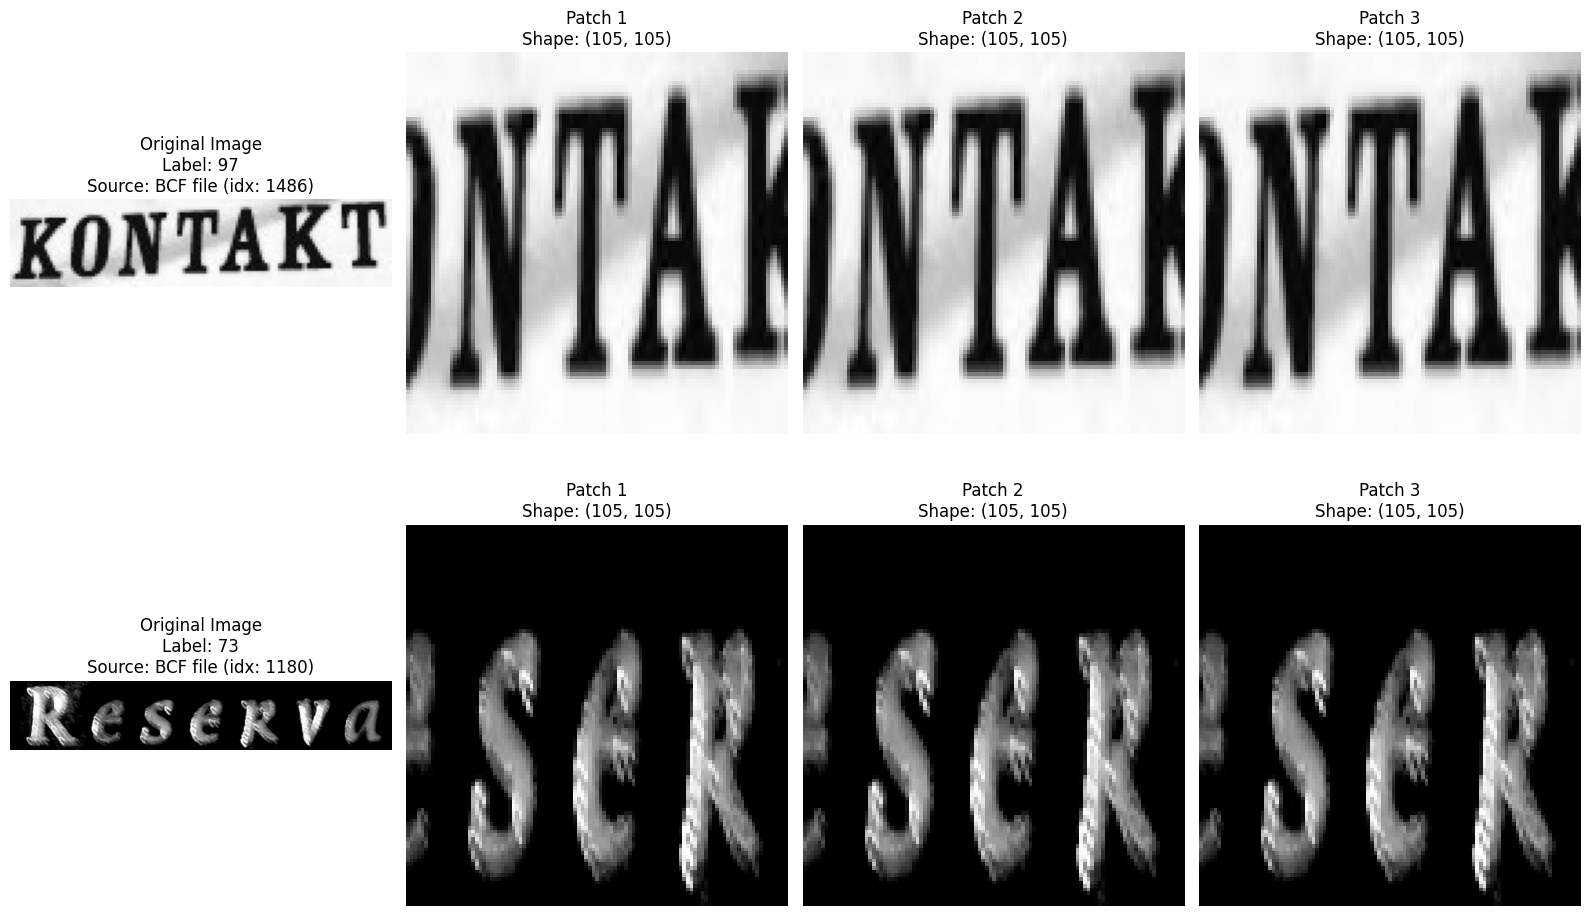

[1486, 1180]

In [136]:
# Visualization some samples from the combined dataset 
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageFile
from io import BytesIO
import os

def visualize_simple_images_and_patches(dataset, num_images=2, seed=None):
    # Allow loading of truncated images
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
    
    # Find valid images (with patches)
    valid_indices = []
    attempts = 0
    max_attempts = min(len(dataset) * 2, 100)  # Limit search attempts
    
    while len(valid_indices) < num_images and attempts < max_attempts:
        idx = random.randint(0, len(dataset) - 1)
        if idx not in valid_indices:  # Avoid duplicates
            try:
                patches, label = dataset[idx]
                if patches and len(patches) > 0:
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Error loading index {idx}: {e}")
            attempts += 1
    
    # If we couldn't find enough valid images
    if len(valid_indices) < num_images:
        print(f"Warning: Could only find {len(valid_indices)} valid images with patches")
        if len(valid_indices) == 0:
            print("No valid images found. Check your dataset.")
            return
    
    # Create figure with enough space for all elements
    fig, axes = plt.subplots(len(valid_indices), 4, figsize=(16, 5 * len(valid_indices)))
    
    # If only one image is requested, make axes indexable as 2D
    if len(valid_indices) == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(valid_indices):
        try:
            # Get item directly from dataset
            patches, label = dataset[idx]
            
            # Get the original full image
            img_array = None
            
            if hasattr(dataset, 'jpeg_data') and idx < len(dataset.jpeg_data):
                # From jpeg_data
                img_path, _ = dataset.jpeg_data[idx]
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {os.path.basename(img_path)}"
                
            elif hasattr(dataset, 'image_filenames') and not hasattr(dataset, 'num_images'):
                # From BCFImagePatchDataset with JPEG source
                img_path = os.path.join(dataset.data_source, dataset.image_filenames[idx])
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {dataset.image_filenames[idx]}"
                
            else:
                # From BCF file (either CombinedImageDataset or BCFImagePatchDataset)
                if hasattr(dataset, 'bcf_data'):
                    # CombinedImageDataset
                    bcf_idx = idx - len(dataset.jpeg_data)
                    if bcf_idx < 0 or bcf_idx >= len(dataset.bcf_data):
                        print(f"Invalid BCF index: {bcf_idx}")
                        continue
                        
                    offset = dataset.image_offsets[bcf_idx]
                    size = dataset.image_sizes[bcf_idx]
                    data_file = dataset.bcf_file
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {bcf_idx})"
                else:
                    # BCFImagePatchDataset
                    offset = dataset.image_offsets[idx]
                    size = dataset.image_sizes[idx]
                    data_file = dataset.data_source
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {idx})"
                
                with open(data_file, 'rb') as f:
                    f.seek(data_start + offset)
                    image_bytes = f.read(size)
                img = Image.open(BytesIO(image_bytes)).convert('L')
                img_array = np.array(img)
            
            # Plot original image if we successfully loaded it
            if img_array is not None:
                axes[i, 0].imshow(img_array, cmap='gray')
                axes[i, 0].set_title(f"Original Image\nLabel: {label}\nSource: {source}")
                axes[i, 0].axis('off')
            else:
                axes[i, 0].text(0.5, 0.5, "Image loading failed", ha='center', va='center')
                axes[i, 0].axis('off')
            
            # Plot the patches - ensure we have patches to display
            if patches and len(patches) > 0:
                for j in range(3):
                    if j < len(patches):
                        patch = patches[j]
                        axes[i, j+1].imshow(patch, cmap='gray')
                        axes[i, j+1].set_title(f"Patch {j+1}\nShape: {patch.shape}")
                    else:
                        # No more patches to display
                        axes[i, j+1].text(0.5, 0.5, "No patch", ha='center', va='center')
                    axes[i, j+1].axis('off')
            else:
                # No patches for this image
                for j in range(3):
                    axes[i, j+1].text(0.5, 0.5, "No patches extracted", ha='center', va='center')
                    axes[i, j+1].axis('off')
            
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            # Create error message in subplot
            for j in range(4):
                axes[i, j].text(0.5, 0.5, f"Error: {str(e)[:50]}...", ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Return the indices we used (helpful for debugging)
    return valid_indices

# Example usage:
visualize_simple_images_and_patches(dataset)

In [ ]:
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {images.size()}, Labels size: {labels.size()}")
    break  # Just check the first batch

In [ ]:
# train_memory_efficient_model

import torch.cuda.amp as amp
import gc

def train_memory_efficient_model(model, train_loader, val_loader=None, 
                                num_epochs=5, learning_rate=0.0001,
                                checkpoint_dir="/kaggle/working/"):
    """
    Memory-efficient training function for SCAE model.
    """
    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Setup device and optimization tools
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device} with {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")
    
    # Move model to device
    model = model.to(device)
    
    # Set up mixed precision training
    scaler = amp.GradScaler()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    # Track best model
    best_val_loss = float('inf')
    patience_counter = 0
    
    try:
        for epoch in range(num_epochs):
            # Clean memory before each epoch
            gc.collect()
            torch.cuda.empty_cache()
            
            # TRAINING PHASE
            model.train()
            running_loss = 0.0
            valid_batches = 0
            
            # Use tqdm for progress tracking
            pbar = tqdm(train_loader)
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train]")
            
            for batch_idx, (patches, _) in enumerate(pbar):
                # Skip empty batches
                if patches.numel() == 0:
                    continue
                
                # Move data to device
                patches = patches.to(device, non_blocking=True)
                
                # Mixed precision forward pass
                with amp.autocast():
                    outputs = model(patches)
                    loss = criterion(outputs, patches)
                
                # Backward pass with gradient scaling
                optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update metrics
                running_loss += loss.item()
                valid_batches += 1
                
                # Update progress bar
                pbar.set_postfix(loss=f"{loss.item():.4f}")
                
                # Aggressive memory cleanup every few batches
                if batch_idx % 10 == 0:
                    del outputs, loss, patches
                    gc.collect()
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
            
            # Calculate epoch metrics
            if valid_batches > 0:
                train_loss = running_loss / valid_batches
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")
            else:
                print(f"Epoch {epoch+1}/{num_epochs}, No valid batches!")
                continue
                
            # Save checkpoint every epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pt")
            
            # VALIDATION PHASE
            if val_loader:
                val_loss = validate_memory_efficient(model, val_loader, criterion, device)
                scheduler.step(val_loss)
                
                # Early stopping logic
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pt")
                    print(f"New best model saved with val_loss: {val_loss:.6f}")
                else:
                    patience_counter += 1
                    if patience_counter >= 3:  # Adjust patience as needed
                        print("Early stopping triggered!")
                        break
    
    except Exception as e:
        print(f"Error during training: {e}")
        # Save emergency checkpoint
        torch.save(model.state_dict(), f"{checkpoint_dir}/emergency_model.pt")
        raise
        
    return model

def validate_memory_efficient(model, val_loader, criterion, device):
    """Memory-efficient validation function."""
    model.eval()
    running_loss = 0.0
    valid_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader)
        pbar.set_description(f"Validating")
        
        for patches, _ in pbar:
            if patches.numel() == 0:
                continue
                
            patches = patches.to(device, non_blocking=True)
            
            # Using mixed precision even for validation
            with amp.autocast():
                outputs = model(patches)
                loss = criterion(outputs, patches)
                
            running_loss += loss.item()
            valid_batches += 1
            
            # Update progress bar
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            
            # Clean up
            del outputs, patches, loss
    
    if valid_batches > 0:
        val_loss = running_loss / valid_batches
        print(f"Validation Loss: {val_loss:.6f}")
        return val_loss
    else:
        print("No valid validation batches!")
        return float('inf')

In [ ]:
# SCAE
import torch.nn as nn
class SCAE(nn.Module):
    def __init__(self, normalization_type="batch_norm", use_dropout=False, dropout_prob=0.3, activation="relu"):
        super(SCAE, self).__init__()

        def norm_layer(num_features):
            if normalization_type == "batch_norm":
                return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm":
                return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm":
                return nn.LayerNorm([num_features, 12, 12])  # Updated for 12x12 feature maps
            else:
                return nn.Identity()

        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)

        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()

        # Encoder: Input 105x105 -> Output 12x12
        self.encoder = nn.Sequential(
            # Layer 1: 105x105 -> 48x48
            nn.Conv2d(1, 64, kernel_size=11, stride=2, padding=0),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),
            
            # Layer 2: 48x48 -> 24x24
            nn.MaxPool2d(2, 2),
            
            # Layer 3: 24x24 -> 24x24
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            norm_layer(128),
            activation_layer(),
            dropout_layer(),
            
            # Layer 4: 24x24 -> 12x12 (added to get 12x12 output)
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder: Input 12x12 -> Output 105x105
        self.decoder = nn.Sequential(
            # Layer 1: 12x12 -> 24x24
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            norm_layer(64),
            activation_layer(),
            dropout_layer(),
            
            # Layer 2: 24x24 -> 48x48
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            norm_layer(32),
            activation_layer(),
            dropout_layer(),
            
            # Layer 3: 48x48 -> 105x105 (with precise output size)
            nn.ConvTranspose2d(32, 1, kernel_size=14, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Pass through encoder
        if x.size(1) == 3:
            # Use standard RGB to grayscale conversion: 0.299*R + 0.587*G + 0.114*B
            x = 0.299 * x[:, 0:1] + 0.587 * x[:, 1:2] + 0.114 * x[:, 2:3]
        for layer in self.encoder:
            x = layer(x)
            # print(x.shape)

        for layer in self.decoder:
            x = layer(x)
            # print(x.shape)
            
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scae = SCAE().to(device)


In [ ]:
(scae(sample[0].to(device)))

In [ ]:
# SCAE (Tu's version)
import torch
import torch.nn as nn
class SCAE(nn.Module):
    def __init__(self, normalization_type="batch_norm", use_dropout=False, dropout_prob=0.3, activation="relu"):
        super(SCAE, self).__init__()
        def norm_layer(num_features):
            if normalization_type == "batch_norm": return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm": return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm": return nn.LayerNorm([num_features, 48, 48])
            else: return nn.Identity()
        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)
        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()

        # Encoder: conv1 → pool1 → conv2
        self.conv1 = nn.Conv2d(1, 64, kernel_size=11, stride=2, padding=0)  # 105x105 → 48x48
        self.norm1 = norm_layer(64)
        self.act1 = activation_layer()
        self.drop1 = dropout_layer()
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)                # 48x48 → 24x24

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # 24x24 → 24x24
        self.norm2 = norm_layer(128)
        self.act2 = activation_layer()
        self.drop2 = dropout_layer()

        # Decoder: deconv1 → unpool1 → deconv2
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1) # 24x24 → 24x24
        self.norm3 = norm_layer(64)
        self.act3 = activation_layer()
        self.drop3 = dropout_layer()
        self.unpool1 = nn.MaxUnpool2d(2, 2)                                           # 24x24 → 48x48

        self.deconv2 = nn.ConvTranspose2d(64, 1, kernel_size=11, stride=2, padding=0) # 48x48 → 105x105
        # No normalization/activation after last layer for output
        self.final_act = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x, indices = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.act2(x)
        x = self.drop2(x)
        # Decoder
        x = self.deconv1(x)
        x = self.norm3(x)
        x = self.act3(x)
        x = self.drop3(x)
        x = self.unpool1(x, indices, output_size=torch.Size([x.size(0), x.size(1), 48, 48]))
        x = self.deconv2(x)
        x = self.final_act(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SCAE().to(device)

In [ ]:
len(train_loader)

In [ ]:
del model, optimizer

In [ ]:
# Create model and train with memory optimization

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SCAE().to(device)
trained_model = train_memory_efficient_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    learning_rate=0.0001
)

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/checkpoint")

In [ ]:
# test
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from functools import partial
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
import gc


def clean_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Evaluate reconstruction quality with metrics (SSIM, PSNR, MSE) 
    and visualize original vs reconstructed images
    """
    model.eval()
    
    # Initialize metrics
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    
    # Get a batch of images for visualization
    vis_images = []
    vis_recons = []
    
    with torch.no_grad():
        # Get one batch for metrics and visualization
        for images, _ in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            reconstructions = model(images)
            
            # Calculate MSE
            mse = torch.mean((reconstructions - images) ** 2).item()
            total_mse += mse
            
            # Convert tensors to numpy for SSIM and PSNR calculation
            images_np = images.cpu().numpy()
            recons_np = reconstructions.cpu().numpy()
            
            # Calculate metrics for each image in the batch
            batch_size = images_np.shape[0]
            for i in range(min(batch_size, num_samples - count)):
                # Get single image (remove batch and channel dimensions)
                img = np.squeeze(images_np[i])
                recon = np.squeeze(recons_np[i])
                
                # Calculate SSIM (structural similarity index)
                ssim_val = ssim(img, recon, data_range=1.0)
                total_ssim += ssim_val
                
                # Calculate PSNR (peak signal-to-noise ratio)
                psnr_val = psnr(img, recon, data_range=1.0)
                total_psnr += psnr_val
                
                # Save images for visualization
                if count < num_samples:
                    vis_images.append(images[i])
                    vis_recons.append(reconstructions[i])
                
                count += 1
                
                if count >= num_samples:
                    break
            
            if count >= num_samples:
                break
    
    # Calculate averages
    avg_mse = total_mse / (count // batch_size + 1)
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    
    # Print metrics
    print(f"Reconstruction Metrics:")
    print(f"  Average MSE: {avg_mse:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f} (higher is better, max 1.0)")
    print(f"  Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    
    # Visualize original vs reconstructed images
    if len(vis_images) > 0:
        # Combine original and reconstructed images for side-by-side comparison
        vis_combined = []
        for img, recon in zip(vis_images, vis_recons):
            vis_combined.extend([img, recon])
        
        # Create a grid of images
        grid = make_grid(vis_combined, nrow=2, normalize=True, pad_value=1)
        plt.figure(figsize=(12, num_samples*2))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Original (left) vs Reconstructed (right)')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'reconstruction_comparison.png'), bbox_inches='tight')
            print(f"Saved reconstruction comparison to {save_path}")
        plt.show()
    
    return {
        'mse': avg_mse,
        'ssim': avg_ssim,
        'psnr': avg_psnr
    }

def evaluate_classification(model, dataloader, device, num_classes, save_path=None):
    """
    Evaluate classification performance if your SCAE includes classification capability
    """
    model.eval()
    
    # Check if model has a classify method or classification head
    if not hasattr(model, 'classify') and not hasattr(model, 'classification_head'):
        print("Model doesn't appear to have classification capability")
        return None
        
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            labels = labels.to(device)
            
            # Get predictions - adapt this to your model's API
            try:
                if hasattr(model, 'classify'):
                    preds = model.classify(images)
                else:
                    # Assume model returns (reconstructions, classifications) if called with return_classifications=True
                    _, preds = model(images, return_classifications=True)
                
                # Convert to class indices
                _, predicted = torch.max(preds.data, 1)
                
                # Store predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            except Exception as e:
                print(f"Error during classification evaluation: {e}")
                return None
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Classification Accuracy: {accuracy:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    if save_path:
        plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

def visualize_latent_space(model, dataloader, device, save_path=None):
    """
    Visualize the latent space of the autoencoder using t-SNE
    """
    try:
        from sklearn.manifold import TSNE
        
        # Get encoder output for a batch of images
        model.eval()
        latent_vectors = []
        labels = []
        
        with torch.no_grad():
            for images, batch_labels in dataloader:
                if images.numel() == 0:
                    continue
                    
                images = images.to(device)
                
                # Get latent vectors - adapt this to your model's API
                if hasattr(model, 'encode'):
                    latent = model.encode(images)
                else:
                    # Try to extract the latent representation from your model
                    # This depends on your model's architecture
                    x = images
                    for layer in model.encoder:
                        x = layer(x)
                    latent = x
                
                # Flatten the latent vectors
                batch_size = images.size(0)
                latent_flat = latent.view(batch_size, -1).cpu().numpy()
                
                latent_vectors.append(latent_flat)
                labels.append(batch_labels.numpy())
                
                if len(latent_vectors) * batch_size >= 1000:  # Limit number of points for t-SNE
                    break
        
        # Concatenate batches
        latent_vectors = np.vstack(latent_vectors)
        labels = np.concatenate(labels)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latent_vectors)
        
        # Plot t-SNE results
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, label='Font Class')
        plt.title('t-SNE Visualization of Latent Space')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_tsne.png'), bbox_inches='tight')
        plt.show()
        
        return latent_tsne, labels
        
    except Exception as e:
        print(f"Error in latent space visualization: {e}")
        return None, None

def generate_samples_from_latent(model, num_samples=10, latent_dim=128, device=None, save_path=None):
    """
    Generate new images by sampling from the latent space (like in VAE)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    
    try:
        # Generate random latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)
        
        # Generate images
        with torch.no_grad():
            if hasattr(model, 'decode'):
                generated = model.decode(z)
            else:
                print("Model doesn't have a decode method. Cannot generate samples.")
                return None
        
        # Visualize generated images
        grid = make_grid(generated.cpu(), nrow=5, normalize=True, pad_value=1)
        plt.figure(figsize=(12, 6))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Generated Samples from Random Latent Vectors')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'generated_samples.png'), bbox_inches='tight')
        plt.show()
        
        return generated
        
    except Exception as e:
        print(f"Error generating samples from latent space: {e}")
        print(f"Your model might not support the VAE-style generation.")
        return None

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Interpolate between two points in latent space and decode them
    """
    model.eval()
    
    try:
        # Get two images from the dataset
        for images, _ in dataloader:
            if images.shape[0] >= 2 and images.numel() > 0:
                break
        else:
            print("Couldn't find suitable images for interpolation")
            return None
            
        # Select two images
        img1 = images[0:1].to(device)
        img2 = images[1:2].to(device)
        
        # Get latent representations
        with torch.no_grad():
            if hasattr(model, 'encode'):
                z1 = model.encode(img1)
                z2 = model.encode(img2)
            else:
                # Try to extract the latent representation
                x1 = img1
                x2 = img2
                for layer in model.encoder:
                    x1 = layer(x1)
                    x2 = layer(x2)
                z1 = x1
                z2 = x2
        
        # Interpolate between the two latent vectors
        interpolations = []
        with torch.no_grad():
            for alpha in np.linspace(0, 1, steps):
                z_interp = alpha * z1 + (1 - alpha) * z2
                
                # Decode the interpolated latent vector
                if hasattr(model, 'decode'):
                    decoded = model.decode(z_interp)
                else:
                    decoded = model.decoder(z_interp)
                
                interpolations.append(decoded)
        
        # Combine original images and interpolation
        all_images = [img1.cpu()]
        all_images.extend([interp.cpu() for interp in interpolations])
        all_images.append(img2.cpu())
        
        # Create a grid
        grid = make_grid(torch.cat(all_images), nrow=steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Latent Space Interpolation')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), bbox_inches='tight')
        plt.show()
        
        return interpolations
        
    except Exception as e:
        print(f"Error during latent space interpolation: {e}")
        return None

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create output directory for visualizations
    save_dir = "/kaggle/working/evaluation_results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Define paths
    model_path = "/kaggle/working/best_model.pt"
    jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
    bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
    label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
    
    try:
        # Load your trained model
        model = SCAE()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Load dataset
        test_dataset = CombinedImageDataset(
            jpeg_dir=jpeg_dir, 
            bcf_file=bcf_file, 
            label_file=label_file,
            num_patch=1,  # Use fewer patches to save memory
            patch_size=(105, 105)
        )
        
        # Create test loader with smaller batch size
        collate_fn = partial(patch_collate_fn, patch_size_tuple=(105, 105))
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=32,  # Use a smaller batch size
            shuffle=True,   # Shuffle to get diverse examples
            num_workers=2,
            collate_fn=collate_fn
        )
        
        print("Dataset and DataLoader prepared")
        
        # Evaluate reconstruction quality
        print("\n1. Evaluating reconstruction quality...")
        recon_metrics = evaluate_reconstruction(
            model, test_loader, device, num_samples=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        # If model has classification capability, evaluate it
        print("\n2. Evaluating classification performance...")
        try:
            class_metrics = evaluate_classification(
                model, test_loader, device, num_classes=2383, save_path=save_dir
            )
        except:
            print("Classification evaluation skipped - model may not support classification")
        clean_gpu_memory()
        
        # Visualize latent space
        print("\n3. Visualizing latent space with t-SNE...")
        latent_tsne, labels = visualize_latent_space(
            model, test_loader, device, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Generate samples from random latent vectors (if model supports it)
        print("\n4. Generating samples from latent space...")
        try:
            # Determine latent dimension from model structure
            # This is just a guess - adapt to your model
            latent_dim = 128
            generated_samples = generate_samples_from_latent(
                model, num_samples=16, latent_dim=latent_dim, device=device, save_path=save_dir
            )
        except:
            print("Sample generation skipped - model may not support VAE-style generation")
        clean_gpu_memory()
        
        # Interpolate in latent space
        print("\n5. Creating latent space interpolation...")
        try:
            interpolations = interpolate_latent_space(
                model, test_loader, device, steps=8, save_path=save_dir
            )
        except:
            print("Latent interpolation skipped - model may not support this operation")
        clean_gpu_memory()
        
        print(f"\nEvaluation complete! Results saved to {save_dir}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [ ]:
# evaluation code
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import gc
from functools import partial
from torch.utils.data import DataLoader

def clean_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Evaluate reconstruction quality with metrics (SSIM, PSNR, MSE)
    and visualize original vs reconstructed images
    """
    model.eval()
    
    # Initialize metrics
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    
    # Get a batch of images for visualization
    vis_images = []
    vis_recons = []
    
    with torch.no_grad():
        # Get one batch for metrics and visualization
        for images, _ in dataloader:
            if images.numel() == 0:
                continue
                
            images = images.to(device)
            reconstructions = model(images)
            
            # Calculate MSE
            mse = torch.mean((reconstructions - images) ** 2).item()
            total_mse += mse
            
            # Convert tensors to numpy for SSIM and PSNR calculation
            images_np = images.cpu().numpy()
            recons_np = reconstructions.cpu().numpy()
            
            # Calculate metrics for each image in the batch
            batch_size = images_np.shape[0]
            for i in range(min(batch_size, num_samples - count)):
                # Get single image (remove batch and channel dimensions)
                img = np.squeeze(images_np[i])
                recon = np.squeeze(recons_np[i])
                
                # Calculate SSIM (structural similarity index)
                ssim_val = ssim(img, recon, data_range=1.0)
                total_ssim += ssim_val
                
                # Calculate PSNR (peak signal-to-noise ratio)
                psnr_val = psnr(img, recon, data_range=1.0)
                total_psnr += psnr_val
                
                # Save images for visualization
                if count < num_samples:
                    vis_images.append(images[i])
                    vis_recons.append(reconstructions[i])
                
                count += 1
                
                if count >= num_samples:
                    break
            
            if count >= num_samples:
                break
    
    # Calculate averages
    avg_mse = total_mse / (count // batch_size + 1)
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    
    # Print metrics
    print(f"Reconstruction Metrics:")
    print(f"  Average MSE: {avg_mse:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f} (higher is better, max 1.0)")
    print(f"  Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    
    # Visualize original vs reconstructed images
    if len(vis_images) > 0:
        # Combine original and reconstructed images for side-by-side comparison
        vis_combined = []
        for img, recon in zip(vis_images, vis_recons):
            vis_combined.extend([img, recon])
        
        # Create a grid of images
        grid = make_grid(vis_combined, nrow=2, normalize=True, pad_value=1)
        plt.figure(figsize=(12, num_samples*2))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Original (left) vs Reconstructed (right)')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'reconstruction_comparison.png'), bbox_inches='tight')
            print(f"Saved reconstruction comparison to {save_path}")
        plt.show()
    
    return {
        'mse': avg_mse,
        'ssim': avg_ssim,
        'psnr': avg_psnr
    }

def extract_latent_features(model, x):
    """
    Extract latent features from the model by running through the encoder part only
    Adapted specifically for the new SCAE architecture
    """
    # Apply encoder operations manually based on your model's structure
    x = model.conv1(x)
    x = model.norm1(x)
    x = model.act1(x)
    x = model.drop1(x)
    x, indices = model.pool1(x)
    x = model.conv2(x)
    x = model.norm2(x)
    x = model.act2(x)
    x = model.drop2(x)
    return x, indices

def generate_from_latent(model, latent, indices, output_size):
    """
    Generate images from latent features by running through the decoder part only
    Adapted specifically for the new SCAE architecture
    """
    # Apply decoder operations manually based on your model's structure
    x = model.deconv1(latent)
    x = model.norm3(x)
    x = model.act3(x)
    x = model.drop3(x)
    x = model.unpool1(x, indices, output_size=output_size)
    x = model.deconv2(x)
    x = model.final_act(x)
    return x

def visualize_latent_space(model, dataloader, device, save_path=None):
    """
    Visualize the latent space of the autoencoder using t-SNE
    """
    try:
        from sklearn.manifold import TSNE
        
        # Get encoder output for a batch of images
        model.eval()
        latent_vectors = []
        orig_shapes = []
        indices_list = []
        labels = []
        
        with torch.no_grad():
            for images, batch_labels in dataloader:
                if images.numel() == 0:
                    continue
                    
                images = images.to(device)
                
                # Get latent vectors using our custom function
                latent, indices = extract_latent_features(model, images)
                
                # Flatten the latent vectors for t-SNE
                batch_size = images.size(0)
                latent_flat = latent.view(batch_size, -1).cpu().numpy()
                
                latent_vectors.append(latent_flat)
                labels.append(batch_labels.numpy())
                
                # Store original shapes and indices for potential reconstruction
                for i in range(batch_size):
                    orig_shapes.append(torch.Size([1, latent.size(1), latent.size(2), latent.size(3)]))
                    indices_list.append(indices[i:i+1])
                
                if len(latent_vectors) * batch_size >= 1000:  # Limit number of points for t-SNE
                    break
        
        # Concatenate batches
        latent_vectors = np.vstack(latent_vectors)
        labels = np.concatenate(labels)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latent_vectors)
        
        # Plot t-SNE results
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, label='Font Class')
        plt.title('t-SNE Visualization of Latent Space')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_tsne.png'), bbox_inches='tight')
        plt.show()
        
        return latent_tsne, labels, latent_vectors, orig_shapes, indices_list
        
    except Exception as e:
        print(f"Error in latent space visualization: {e}")
        return None, None, None, None, None

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Interpolate between two points in latent space and decode them
    Adapted for the new SCAE architecture
    """
    model.eval()
    
    try:
        # Get two images from the dataset
        for images, _ in dataloader:
            if images.shape[0] >= 2 and images.numel() > 0:
                break
        else:
            print("Couldn't find suitable images for interpolation")
            return None
            
        # Select two images
        img1 = images[0:1].to(device)
        img2 = images[1:2].to(device)
        
        # Get latent representations and indices for unpooling
        with torch.no_grad():
            z1, indices1 = extract_latent_features(model, img1)
            z2, indices2 = extract_latent_features(model, img2)
        
        # Get output size for the unpool operation
        output_size = torch.Size([1, z1.size(1), 48, 48])  # Based on your architecture
        
        # Interpolate between the two latent vectors
        interpolations = []
        with torch.no_grad():
            for alpha in np.linspace(0, 1, steps):
                z_interp = alpha * z1 + (1 - alpha) * z2
                
                # Use indices from first image for interpolation (simplification)
                decoded = generate_from_latent(model, z_interp, indices1, output_size)
                
                interpolations.append(decoded)
        
        # Combine original images and interpolation
        all_images = []
        with torch.no_grad():
            # Add the first original image
            all_images.append(img1.cpu())
            # Add interpolations
            all_images.extend([interp.cpu() for interp in interpolations])
            # Add the second original image
            all_images.append(img2.cpu())
        
        # Create a grid
        grid = make_grid(torch.cat(all_images), nrow=steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Latent Space Interpolation')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), bbox_inches='tight')
        plt.show()
        
        return interpolations
        
    except Exception as e:
        print(f"Error during latent space interpolation: {e}")
        return None

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create output directory for visualizations
    save_dir = "evaluation_results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Define paths
    model_path = "/kaggle/working/best_model.pt"
    jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
    bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
    label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
    
    try:
        # Import necessary modules - add these imports here to avoid issues in Kaggle
        # Load your trained model
        model = SCAE()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Load dataset
        combined_dataset = CombinedImageDataset(
            jpeg_dir=jpeg_dir,
            bcf_file=bcf_file,
            label_file=label_file,
            num_patch=3,  # Reduced from 3
        )
    
        # Create memory-optimized dataloaders with smaller batch size
        test_loader, val_loader = create_patch_dataloaders(
            combined_dataset,
            batch_size=512,  # Reduced from 1024
            num_workers=2,   # Reduced from 4
            val_split=0
        )
        # test_dataset = CombinedImageDataset(
        #     jpeg_dir=jpeg_dir, 
        #     bcf_file=bcf_file, 
        #     label_file=label_file,
        #     num_patch=3,  # Use fewer patches to save memory
        #     patch_size=(105, 105)
        # )
        
        # # Create test loader with smaller batch size
        # collate_fn = partial(patch_collate_fn, patch_size_tuple=(105, 105))
        # test_loader = DataLoader(
        #     test_dataset,
        #     batch_size=128,  # Use a smaller batch size
        #     shuffle=True,   # Shuffle to get diverse examples
        #     num_workers=2,
        #     collate_fn=collate_fn
        # )
        
        print("Dataset and DataLoader prepared")
        
        # Evaluate reconstruction quality
        print("\n1. Evaluating reconstruction quality...")
        recon_metrics = evaluate_reconstruction(
            model, test_loader, device, num_samples=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Visualize latent space
        print("\n2. Visualizing latent space with t-SNE...")
        latent_tsne, labels, latent_vectors, orig_shapes, indices_list = visualize_latent_space(
            model, test_loader, device, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Interpolate in latent space
        print("\n3. Creating latent space interpolation...")
        interpolations = interpolate_latent_space(
            model, test_loader, device, steps=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        print(f"\nEvaluation complete! Results saved to {save_dir}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import gc
from functools import partial
from torch.utils.data import DataLoader

def clean_gpu_memory():
    """Clean up GPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

def evaluate_reconstruction(model, dataloader, device, num_samples=10, save_path=None):
    """
    Evaluate reconstruction quality with metrics (SSIM, PSNR, MSE)
    and visualize original vs reconstructed images
    """
    model.eval()
    
    # Initialize metrics
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    count = 0
    
    # Get a batch of images for visualization
    vis_images = []
    vis_recons = []
    
    with torch.no_grad():
        # Get one batch for metrics and visualization
        for images, _ in dataloader:
            # Skip empty batches
            if images.numel() == 0:
                continue
                
            # Ensure we have the right shape for processing
            if len(images.shape) == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
                
            images = images.to(device)
            reconstructions = model(images)
            
            # Calculate MSE
            mse = torch.mean((reconstructions - images) ** 2).item()
            total_mse += mse
            
            # Convert tensors to numpy for SSIM and PSNR calculation
            images_np = images.cpu().numpy()
            recons_np = reconstructions.cpu().numpy()
            
            # Calculate metrics for each image in the batch
            batch_size = images_np.shape[0]
            for i in range(min(batch_size, num_samples - count)):
                # Get single image (remove batch and channel dimensions if needed)
                img = np.squeeze(images_np[i])
                recon = np.squeeze(recons_np[i])
                
                # If image has 3 channels, convert to grayscale for SSIM/PSNR calculation
                if len(img.shape) == 3 and img.shape[0] == 3:
                    img_gray = np.mean(img, axis=0)
                    recon_gray = np.mean(recon, axis=0)
                    ssim_val = ssim(img_gray, recon_gray, data_range=1.0)
                    psnr_val = psnr(img_gray, recon_gray, data_range=1.0)
                else:
                    # Ensure images are properly squeezed but retain needed dimensions
                    if len(img.shape) > 2:
                        img = np.squeeze(img)
                    if len(recon.shape) > 2:
                        recon = np.squeeze(recon)
                    
                    # Handle case where squeeze removed too many dimensions
                    if len(img.shape) == 0:
                        img = img.reshape(1, 1)
                    if len(recon.shape) == 0:
                        recon = recon.reshape(1, 1)
                        
                    ssim_val = ssim(img, recon, data_range=1.0)
                    psnr_val = psnr(img, recon, data_range=1.0)
                
                total_ssim += ssim_val
                total_psnr += psnr_val
                
                # Save images for visualization
                if count < num_samples:
                    vis_images.append(images[i])
                    vis_recons.append(reconstructions[i])
                
                count += 1
                
                if count >= num_samples:
                    break
            
            if count >= num_samples:
                break
    
    # Calculate averages
    if count > 0:
        avg_mse = total_mse / (count // batch_size + 1)
        avg_ssim = total_ssim / count
        avg_psnr = total_psnr / count
    else:
        avg_mse = float('nan')
        avg_ssim = float('nan')
        avg_psnr = float('nan')
        print("Warning: No valid samples were processed in evaluation")
    
    # Print metrics
    print(f"Reconstruction Metrics:")
    print(f"  Average MSE: {avg_mse:.4f}")
    print(f"  Average SSIM: {avg_ssim:.4f} (higher is better, max 1.0)")
    print(f"  Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    
    # Visualize original vs reconstructed images
    if len(vis_images) > 0:
        # Combine original and reconstructed images for side-by-side comparison
        vis_combined = []
        for img, recon in zip(vis_images, vis_recons):
            vis_combined.extend([img, recon])
        
        # Create a grid of images
        grid = make_grid(vis_combined, nrow=2, normalize=True, pad_value=1)
        plt.figure(figsize=(12, num_samples*2))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title('Original (left) vs Reconstructed (right)')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'reconstruction_comparison.png'), bbox_inches='tight')
            print(f"Saved reconstruction comparison to {save_path}")
        plt.show()
    
    return {
        'mse': avg_mse,
        'ssim': avg_ssim,
        'psnr': avg_psnr
    }

def safely_extract_latent_features(model, x):
    """
    Extract latent features from the model - with safety checks and error handling
    Handles various model architectures by attempting different approaches
    """
    try:
        # Method 1: Direct call to encoder if available
        if hasattr(model, 'encode'):
            return model.encode(x)
        
        # Method 2: Manual application of encoder layers as in original code
        # Capture as much as possible through a try/except approach
        try:
            x = model.conv1(x)
            x = model.norm1(x) if hasattr(model, 'norm1') else x
            x = model.act1(x) if hasattr(model, 'act1') else torch.relu(x)
            x = model.drop1(x) if hasattr(model, 'drop1') else x
            
            # Handle pooling layers with or without indices
            if hasattr(model, 'pool1'):
                if 'MaxPool' in model.pool1.__class__.__name__ and 'return_indices=True' in str(model.pool1):
                    x, indices = model.pool1(x)
                else:
                    x = model.pool1(x)
                    indices = None
            else:
                indices = None
                
            # Continue with more layers if they exist
            if hasattr(model, 'conv2'):
                x = model.conv2(x)
                x = model.norm2(x) if hasattr(model, 'norm2') else x
                x = model.act2(x) if hasattr(model, 'act2') else torch.relu(x)
                x = model.drop2(x) if hasattr(model, 'drop2') else x
            
            return x, indices
            
        except Exception as e:
            print(f"Warning: Error in manual feature extraction: {e}")
            
            # Method 3: Simplified approach - extract features up to a bottleneck
            # This is a more generic approach that can work with different model architectures
            features = []
            indices_list = []
            
            # Get all model's modules
            for name, module in model.named_modules():
                # Skip the top level module (the model itself)
                if name == '':
                    continue
                    
                # Apply the layer
                try:
                    if isinstance(module, nn.MaxPool2d) and module.return_indices:
                        x, indices = module(x)
                        indices_list.append(indices)
                    else:
                        x = module(x)
                        
                    # Collect features at bottleneck or certain layers
                    if isinstance(module, (nn.Conv2d, nn.Linear)) and len(features) < 5:
                        features.append(x)
                        
                    # If we've reached the bottleneck/middle of the network, stop
                    if 'bottleneck' in name.lower() or 'latent' in name.lower():
                        break
                        
                except Exception:
                    continue
            
            # If we've collected features, return the last one
            if features:
                return features[-1], indices_list[-1] if indices_list else None
    
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        # Return input as fallback (will produce poor results but prevents crashes)
        return x, None

def safely_generate_from_latent(model, latent, indices=None, output_size=None):
    """
    Generate images from latent features with safety checks and error handling
    Handles various model architectures by attempting different approaches
    """
    try:
        # Method 1: Direct call to decoder if available
        if hasattr(model, 'decode'):
            return model.decode(latent)
        
        # Method 2: Manual application of decoder layers as in original code
        try:
            x = latent
            
            # Apply decoder operations based on model attributes
            if hasattr(model, 'deconv1'):
                x = model.deconv1(x)
                x = model.norm3(x) if hasattr(model, 'norm3') else x
                x = model.act3(x) if hasattr(model, 'act3') else torch.relu(x)
                x = model.drop3(x) if hasattr(model, 'drop3') else x
            
            # Handle unpooling layers if they exist
            if hasattr(model, 'unpool1') and indices is not None:
                x = model.unpool1(x, indices, output_size=output_size)
            
            # Continue with more layers if they exist
            if hasattr(model, 'deconv2'):
                x = model.deconv2(x)
            
            # Apply final activation if it exists
            if hasattr(model, 'final_act'):
                x = model.final_act(x)
            elif hasattr(model, 'sigmoid'):
                x = model.sigmoid(x)
            else:
                x = torch.sigmoid(x)  # Default to sigmoid for image generation
                
            return x
            
        except Exception as e:
            print(f"Warning: Error in manual latent generation: {e}")
            
            # Method 3: Forward pass through the full model as fallback
            # This is a reasonable fallback that should work with most autoencoders
            return model(latent)
    
    except Exception as e:
        print(f"Error in generating from latent: {e}")
        # Return latent as fallback (will produce poor results but prevents crashes)
        return latent

def visualize_latent_space(model, dataloader, device, save_path=None):
    """
    Visualize the latent space of the autoencoder using t-SNE
    """
    try:
        from sklearn.manifold import TSNE
        
        # Get encoder output for a batch of images
        model.eval()
        latent_vectors = []
        orig_shapes = []
        indices_list = []
        labels = []
        
        with torch.no_grad():
            for images, batch_labels in dataloader:
                # Skip empty batches
                if images.numel() == 0:
                    continue
                    
                # Ensure we have the right shape for processing
                if len(images.shape) == 3:
                    images = images.unsqueeze(1)  # Add channel dimension if missing
                    
                images = images.to(device)
                
                # Get latent vectors using our safe extraction function
                latent, indices = safely_extract_latent_features(model, images)
                
                # Flatten the latent vectors for t-SNE
                batch_size = images.size(0)
                
                # Handle case where latent is not a tensor
                if not isinstance(latent, torch.Tensor):
                    print("Warning: Latent features are not a tensor, skipping batch")
                    continue
                
                # Flatten the latent representations
                if len(latent.shape) > 2:
                    latent_flat = latent.reshape(batch_size, -1).cpu().numpy()
                else:
                    latent_flat = latent.cpu().numpy()
                
                latent_vectors.append(latent_flat)
                labels.append(batch_labels.cpu().numpy())
                
                # Store original shapes and indices for potential reconstruction
                for i in range(batch_size):
                    if indices is not None:
                        if isinstance(indices, list):
                            indices_list.append([idx[i:i+1] for idx in indices])
                        else:
                            indices_list.append(indices[i:i+1])
                    else:
                        indices_list.append(None)
                    
                    if len(latent.shape) > 2:
                        orig_shapes.append(torch.Size([1, latent.size(1), latent.size(2), latent.size(3)]))
                    else:
                        # Handle case where latent is already flattened
                        orig_shapes.append(None)
                
                if len(latent_vectors) * batch_size >= 1000:  # Limit number of points for t-SNE
                    break
        
        # Concatenate batches
        if latent_vectors:
            latent_vectors = np.vstack(latent_vectors)
            labels = np.concatenate(labels)
            
            # Apply t-SNE
            tsne = TSNE(n_components=2, random_state=42)
            latent_tsne = tsne.fit_transform(latent_vectors)
            
            # Plot t-SNE results
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
            plt.colorbar(scatter, label='Font Class')
            plt.title('t-SNE Visualization of Latent Space')
            
            if save_path:
                plt.savefig(os.path.join(save_path, 'latent_tsne.png'), bbox_inches='tight')
            plt.show()
            
            return latent_tsne, labels, latent_vectors, orig_shapes, indices_list
        else:
            print("No valid latent vectors were extracted")
            return None, None, None, None, None
        
    except Exception as e:
        print(f"Error in latent space visualization: {e}")
        return None, None, None, None, None

def interpolate_latent_space(model, dataloader, device, steps=10, save_path=None):
    """
    Interpolate between two points in latent space and decode them
    With improved error handling and support for different model architectures
    """
    model.eval()
    
    try:
        # Get two images from the dataset
        valid_images = []
        
        for images, _ in dataloader:
            # Skip empty batches
            if images.numel() == 0:
                continue
                
            # Ensure we have the right shape for processing
            if len(images.shape) == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
                
            valid_images.append(images)
            
            if len(valid_images) > 0 and valid_images[0].shape[0] >= 2:
                break
        
        if not valid_images or valid_images[0].shape[0] < 2:
            print("Couldn't find suitable images for interpolation")
            return None
            
        # Select two images
        img1 = valid_images[0][0:1].to(device)
        img2 = valid_images[0][1:2].to(device)
        
        # Get latent representations and indices for unpooling
        with torch.no_grad():
            z1, indices1 = safely_extract_latent_features(model, img1)
            z2, indices2 = safely_extract_latent_features(model, img2)
            
            # Check if latent features were extracted correctly
            if z1 is None or z2 is None:
                print("Failed to extract latent features for interpolation")
                return None
        
        # Get output size for the unpool operation if needed
        # This is a reasonable default that should work with many architectures
        if len(z1.shape) == 4:
            output_size = torch.Size([1, z1.size(1), z1.size(2)*2, z1.size(3)*2])
        else:
            output_size = None
        
        # Interpolate between the two latent vectors
        interpolations = []
        with torch.no_grad():
            for alpha in np.linspace(0, 1, steps):
                # Linear interpolation in latent space
                z_interp = alpha * z1 + (1 - alpha) * z2
                
                # Use indices from first image for interpolation (simplification)
                decoded = safely_generate_from_latent(model, z_interp, indices1, output_size)
                
                interpolations.append(decoded)
        
        # Combine original images and interpolation
        all_images = []
        with torch.no_grad():
            # Add the first original image
            reconstructed_img1 = model(img1)
            all_images.append(reconstructed_img1.cpu())
            
            # Add interpolations
            all_images.extend([interp.cpu() for interp in interpolations])
            
            # Add the second original image
            reconstructed_img2 = model(img2)
            all_images.append(reconstructed_img2.cpu())
        
        # Create a grid
        grid = make_grid(torch.cat(all_images), nrow=steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Latent Space Interpolation')
        
        if save_path:
            plt.savefig(os.path.join(save_path, 'latent_interpolation.png'), bbox_inches='tight')
        plt.show()
        
        return interpolations
        
    except Exception as e:
        print(f"Error during latent space interpolation: {e}")
        import traceback
        traceback.print_exc()
        return None

def main():
    """
    Main evaluation function that runs all the evaluation steps
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create output directory for visualizations
    save_dir = "evaluation_results"
    os.makedirs(save_dir, exist_ok=True)
    
    # Define paths - make these configurable in your actual implementation
    model_path = "/kaggle/working/best_model.pt"
    jpeg_dir = "/kaggle/input/deepfont-unlab/scrape-wtf-new/scrape-wtf-new"
    bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
    label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
    
    try:        
        # Load your trained model
        model = SCAE()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        print("Model loaded successfully")
        
        # Load dataset
        combined_dataset = CombinedImageDataset(
            jpeg_dir=jpeg_dir,
            bcf_file=bcf_file,
            label_file=label_file,
            num_patch=3,
        )
    
        # Create dataloaders using our fixed implementation
        test_loader, val_loader = create_patch_dataloaders(
            combined_dataset,
            batch_size=64,  # Reduced batch size for better stability
            num_workers=2,
            val_split=0.1,
            patch_size=(105, 105)
        )
        
        print("Dataset and DataLoader prepared")
        
        # Evaluate reconstruction quality
        print("\n1. Evaluating reconstruction quality...")
        recon_metrics = evaluate_reconstruction(
            model, test_loader, device, num_samples=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Visualize latent space
        print("\n2. Visualizing latent space with t-SNE...")
        latent_tsne, labels, latent_vectors, orig_shapes, indices_list = visualize_latent_space(
            model, test_loader, device, save_path=save_dir
        )
        clean_gpu_memory()
        
        # Interpolate in latent space
        print("\n3. Creating latent space interpolation...")
        interpolations = interpolate_latent_space(
            model, test_loader, device, steps=8, save_path=save_dir
        )
        clean_gpu_memory()
        
        print(f"\nEvaluation complete! Results saved to {save_dir}")
        
    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [ ]:
!zip -r /kaggle/working/evaluation_results.zip /kaggle/working/evaluation_results

# Augumentation Steps 
1) Noise
2) Blur
3) Perpective Rotation
4) Shading
5) Variable Character Spacing
6) Variable Aspect Ratio

In [1]:
# augmentation functions
from PIL import ImageFilter, Image
import random
import numpy as np
import cv2

def noise_image(np_img, mean=0, std=2):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)
    img_array = np_img.astype(np.float32)
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = img_array + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    return cv2.resize(noisy_img, (105, 105))

def blur_image(np_img):
    if isinstance(np_img, np.ndarray):
        np_img = Image.fromarray(np_img.astype('uint8'))
    blur_img = np_img.filter(ImageFilter.GaussianBlur(radius=1.5))
    blur_img = blur_img.resize((105, 105))
    return np.array(blur_img)

def affine_rotation(np_img):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if np_img.dtype != np.uint8:
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)

    if len(np_img.shape) == 2:
        np_img = np.expand_dims(np_img, axis=-1)

    rows, cols = np_img.shape[:2]
    src_pts = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
    max_shift = 0.05
    dst_pts = src_pts + np.random.uniform(-max_shift * cols, max_shift * cols, src_pts.shape).astype(np.float32)

    A = cv2.getAffineTransform(src_pts, dst_pts)
    warped = cv2.warpAffine(np_img, A, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    if warped.ndim == 3 and warped.shape[-1] == 1:
        warped = warped[:, :, 0]

    warped = cv2.resize(warped, (105, 105))
    return warped

def gradient_fill(np_img):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if len(np_img.shape) == 3:
        gray = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
    else:
        gray = np_img

    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    abs_lap = np.absolute(laplacian) * 0.5
    lap_uint8 = np.uint8(np.clip(abs_lap, 0, 255))
    lap_resized = cv2.resize(lap_uint8, (105, 105))
    return lap_resized

def variable_aspect_ratio_preprocess(np_img, target_size=(105, 105)):
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if np_img.dtype != np.uint8:
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)

    if len(np_img.shape) == 3:
        h, w, c = np_img.shape
    else:
        h, w = np_img.shape
        c = None

    scale_ratio = np.random.uniform(0.95, 1.05)
    new_width = int(w * scale_ratio)

    resized = cv2.resize(np_img, (new_width, h), interpolation=cv2.INTER_LINEAR)
    final = cv2.resize(resized, target_size, interpolation=cv2.INTER_LINEAR)
    return final

def augmentation_pipeline(np_img):
    """
    Tăng cường ảnh đầu vào với các phép biến đổi ngẫu nhiên.
    Hỗ trợ ảnh grayscale hoặc RGB dưới dạng NumPy array hoặc PIL Image.
    """
    if isinstance(np_img, Image.Image):
        np_img = np.array(np_img)

    if np_img.dtype != np.uint8:
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)

    img = variable_aspect_ratio_preprocess(np_img)

    augmentations = [
        lambda x: noise_image(x),
        lambda x: blur_image(x),
        lambda x: affine_rotation(x),
        lambda x: gradient_fill(x)
    ]

    num_aug = random.randint(1, 3)
    selected_augs = random.sample(augmentations, num_aug)

    for aug in selected_augs:
        img = aug(img)
        if isinstance(img, Image.Image):
            img = np.array(img)
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)

    return img



In [2]:
# extract patches from an image
import easyocr
import numpy as np
import os
import tempfile
from PIL import Image

# Global OCR reader for efficiency
_ocr_reader = None

def get_ocr_reader(languages=["en"]):
    global _ocr_reader
    if _ocr_reader is None:
        _ocr_reader = easyocr.Reader(languages)
    return _ocr_reader

def extract_patches(image_array, num_patch=3, patch_size=(105, 105), 
                    extract_text=True, min_text_coverage=0.3, max_attempts=20):
    # Handle dimension check
    if image_array.ndim == 2:  # Grayscale
        h, w = image_array.shape
        is_grayscale = True
    elif image_array.ndim == 3:  # Color
        h, w, _ = image_array.shape
        is_grayscale = False
    else:
        print(f"Warning: Unexpected image array dimension: {image_array.ndim}")
        return []

    patch_h, patch_w = patch_size

    # Check if image is large enough for at least one patch
    if h < patch_h or w < patch_w:
        return []  # Return empty list if image is too small
        
    # If not extracting text or image is too small, use random patches
    if not extract_text:
        patches = []
        for _ in range(num_patch):
            x = np.random.randint(0, w - patch_w + 1)
            y = np.random.randint(0, h - patch_h + 1)
            if is_grayscale:
                patch = image_array[y:y+patch_h, x:x+patch_w]
            else:
                patch = image_array[y:y+patch_h, x:x+patch_w, :]
            patches.append(patch)
        return patches
        
    # For text extraction, we'll try to find patches with text
    reader = get_ocr_reader()
    text_patches = []
    attempts = 0
    
    # Keep extracting until we have enough or reach max attempts
    while len(text_patches) < num_patch and attempts < max_attempts:
        # Generate a random patch
        x = np.random.randint(0, w - patch_w + 1)
        y = np.random.randint(0, h - patch_h + 1)
        
        if is_grayscale:
            patch = image_array[y:y+patch_h, x:x+patch_w]
        else:
            patch = image_array[y:y+patch_h, x:x+patch_w, :]
            
        # Save patch to temporary file for OCR
        with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as tmp:
            tmp_path = tmp.name
            patch_img = Image.fromarray(patch if is_grayscale else patch)
            patch_img.save(tmp_path)
            
        try:
            # Run OCR on the patch
            ocr_results = reader.readtext(tmp_path)
            
            # Clean up temp file
            os.unlink(tmp_path)
            
            # Calculate total text area
            patch_area = patch_h * patch_w
            text_area = 0
            
            for bbox, text, conf in ocr_results:
                if conf < 0.5:  # Skip low confidence detections
                    continue
                    
                # Convert bbox points to integers
                bbox = [[int(point[0]), int(point[1])] for point in bbox]
                
                # Calculate bbox area (text area)
                text_min_x = max(0, min(point[0] for point in bbox))
                text_max_x = min(patch_w, max(point[0] for point in bbox))
                text_min_y = max(0, min(point[1] for point in bbox))
                text_max_y = min(patch_h, max(point[1] for point in bbox))
                
                box_width = text_max_x - text_min_x
                box_height = text_max_y - text_min_y
                
                if box_width > 0 and box_height > 0:
                    text_area += box_width * box_height
            
            # Check if patch has enough text
            coverage = text_area / patch_area
            if coverage >= min_text_coverage:
                text_patches.append(patch)
                # print(f"Found text patch with coverage {coverage:.2f}")
        
        except Exception as e:
            print(f"Error in OCR: {e}")
            try:
                os.unlink(tmp_path)
            except:
                pass
                
        attempts += 1
    
    # Return whatever text patches we found, even if fewer than requested
    return text_patches

In [3]:
# combined dataset (them moi dong if ... is None, unnecessary bro)
import torch
from PIL import Image
import numpy as np
import os
from io import BytesIO
from datasets import Dataset
import warnings
from torchvision import transforms

class FontDataset(Dataset):
    def __init__(self, jpeg_dir, bcf_file, label_file, num_patch=3, patch_size=(105, 105), 
                 extract_text=False, min_text_coverage=0.3, max_attempts=20, ocr_languages=["en"]):
        self.jpeg_dir = jpeg_dir
        self.bcf_file = bcf_file
        self.label_file = label_file
        self.num_patch = num_patch
        self.patch_size = patch_size
        self.extract_text = extract_text
        self.min_text_coverage = min_text_coverage
        self.max_attempts = max_attempts
        self.ocr_languages = ocr_languages

        # Initialize OCR reader if needed
        if extract_text:
            self.reader = get_ocr_reader(ocr_languages)

        self.jpeg_data = []
        self.bcf_data = []

        # Load jpeg data
        self._load_jpeg_data(jpeg_dir)

        # Load bcf data
        self._load_bcf_data(bcf_file, label_file)

    def _load_jpeg_data(self, jpeg_dir):
        # add login for the case where jpeg_dir is None
        if jpeg_dir is None:
            print("Warning: jpeg_dir is None, skipping JPEG data loading.")
            return
        if not os.path.exists(jpeg_dir):
            print(f"Warning: JPEG directory {jpeg_dir} does not exist.")
            return
            
        image_filenames = [f for f in os.listdir(jpeg_dir) if f.lower().endswith(('.jpeg', '.jpg'))]
        self.jpeg_data = [(os.path.join(jpeg_dir, f), 0) for f in image_filenames]  # Assuming label is 0 for .jpeg files
        print(f"Loaded {len(self.jpeg_data)} .jpeg images.")

    def _load_bcf_data(self, bcf_file, label_file):
        if not (os.path.exists(bcf_file) and os.path.exists(label_file)):
            print(f"Warning: BCF file {bcf_file} or label file {label_file} does not exist.")
            return
            
        try:
            with open(label_file, 'rb') as f:
                self.labels = np.frombuffer(f.read(), dtype=np.uint32)
                print(f"Loaded {len(self.labels)} labels from {label_file}.")

            with open(bcf_file, 'rb') as f:
                self.num_images = np.frombuffer(f.read(8), dtype=np.int64)[0]
                print(f"Loaded {self.num_images} images from {bcf_file}.")

                sizes_bytes = f.read(self.num_images * 8)
                self.image_sizes = np.frombuffer(sizes_bytes, dtype=np.int64)

                self.data_start_offset = 8 + self.num_images * 8
                self.image_offsets = np.zeros(self.num_images + 1, dtype=np.int64)
                np.cumsum(self.image_sizes, out=self.image_offsets[1:])

                for idx in range(self.num_images):
                    self.bcf_data.append((idx, self.labels[idx]))
                
            print(f"Loaded {len(self.bcf_data)} .bcf images.")
        except Exception as e:
            print(f"Error loading .bcf data: {e}")

    def __len__(self):
        return len(self.jpeg_data) + len(self.bcf_data)

    def _extract_patches(self, img_array):
        return extract_patches(
            img_array, 
            num_patch=self.num_patch, 
            patch_size=self.patch_size,
            extract_text=self.extract_text, 
            min_text_coverage=self.min_text_coverage,
            max_attempts=self.max_attempts
        )

    def __getitem__(self, idx):
        if isinstance(idx, list):
            results = []
            labels = []
            for single_idx in idx:
                try:
                    patches, label = self.__getitem__(single_idx)
                    if patches and label != -1:
                        results.append(patches)
                        labels.append(label)
                except Exception as e:
                    print(f"Error processing index {single_idx}: {e}")
            return results, labels

        max_retries = 3
        for retry in range(max_retries):
            try:
                if idx < len(self.jpeg_data):
                    # Handle .jpeg images
                    img_path, label = self.jpeg_data[idx]
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            img = Image.open(img_path)
                            img.verify()

                        img = Image.open(img_path).convert('L')
                        img_array = np.array(img)

                        # ✅ Apply augmentation before extracting patches
                        patches = self._extract_patches(img_array)
                        patches = [augmentation_pipeline(patch) for patch in patches]

                        del img, img_array
                        return patches, label

                    except (OSError, IOError, ValueError) as e:
                        print(f"Warning: Corrupt image at {img_path}: {e}")
                        return [], -1

                else:
                    # Handle .bcf images
                    bcf_idx = idx - len(self.jpeg_data)
                    if bcf_idx >= len(self.bcf_data):
                        return [], -1

                    label = self.bcf_data[bcf_idx][1]
                    offset = self.image_offsets[bcf_idx]
                    size = self.image_sizes[bcf_idx]

                    try:
                        with open(self.bcf_file, 'rb') as f:
                            f.seek(self.data_start_offset + offset)
                            image_bytes = f.read(size)

                        buffer = BytesIO(image_bytes)
                        img = Image.open(buffer)
                        img.verify()

                        buffer.seek(0)
                        img = Image.open(buffer).convert('L')
                        img_array = np.array(img)

                        # ✅ Apply augmentation before extracting patches
                        patches = self._extract_patches(img_array)
                        patches = [augmentation_pipeline(patch) for patch in patches]

                        del img, img_array, buffer, image_bytes
                        return patches, label

                    except (OSError, IOError, ValueError) as e:
                        print(f"Warning: Corrupt BCF image at index {bcf_idx}: {e}")
                        return [], -1

            except Exception as e:
                print(f"Unexpected error processing idx {idx}: {e}")

            if retry < max_retries - 1:
                idx = (int(idx) + 1) % len(self)

        return [], -1


In [4]:
# memory_efficient_patch_collate_fn
import gc
import warnings
from functools import partial

# Add this memory-efficient patch collate function
def memory_efficient_patch_collate_fn(batch, patch_size_tuple):
    """
    Memory-efficient version of patch_collate_fn that processes one patch at a time
    and includes robust error handling.
    """
    import gc  # Import inside function for worker processes
    
    all_patches = []
    all_labels = []
    valid_batch_items = 0

    # Process one item at a time to avoid large memory allocations
    for item in batch:
        patches, label = item
        # Ensure item is valid
        if patches and label != -1:
            # Process patches one by one
            for patch in patches:
                all_patches.append(patch)
                all_labels.append(label)
            valid_batch_items += 1
    
    # Periodically force garbage collection
    if len(all_patches) > 100:
        gc.collect()
    
    # Empty batch handling
    if not all_patches:
        patch_h, patch_w = patch_size_tuple
        return torch.empty((0, 1, patch_h, patch_w), dtype=torch.float), torch.empty((0,), dtype=torch.long)

    # Process in smaller chunks to reduce peak memory usage
    max_chunk_size = 64  # Adjust based on your GPU memory
    num_patches = len(all_patches)
    patches_tensor_list = []
    
    for i in range(0, num_patches, max_chunk_size):
        chunk = all_patches[i:i+max_chunk_size]
        # Convert to NumPy array
        chunk_np = np.stack(chunk)
        # Convert to tensor, normalize and add channel dimension
        chunk_tensor = torch.from_numpy(chunk_np).float() / 255.0
        chunk_tensor = chunk_tensor.unsqueeze(1)
        patches_tensor_list.append(chunk_tensor)
        
        # Clear variables to free memory
        del chunk, chunk_np
    
    # Concatenate chunks
    patches_tensor = torch.cat(patches_tensor_list, dim=0)
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)
    
    # Clean up
    del patches_tensor_list, all_patches, all_labels
    gc.collect()
    
    return patches_tensor, labels_tensor

# Add this function to create optimized DataLoaders
import torch
from torch.utils.data import DataLoader
from functools import partial

def create_optimized_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1):
    """
    Creates DataLoaders with proper error handling, avoiding HuggingFace datasets compatibility issues.
    
    Args:
        dataset: The image dataset instance
        batch_size: Batch size for training
        num_workers: Number of worker processes
        val_split: Validation split ratio (0-1)
        
    Returns:
        tuple: (train_loader, val_loader)
    """
    from torch.utils.data import DataLoader, Subset
    import numpy as np
    
    # Calculate split sizes
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets - this avoids Hugging Face's __getitems__ implementation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    # Custom collate function with error handling
    def safe_collate(batch):
        # Filter out empty or invalid items
        valid_batch = [(patches, label) for patches, label in batch if patches and label != -1]
        
        if not valid_batch:
            # Return empty tensors if no valid items
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
        
        # Process valid items
        all_patches = []
        all_labels = []
        
        for patches, label in valid_batch:
            if isinstance(patches, list) and patches:
                all_patches.extend(patches)
                all_labels.extend([label] * len(patches))
        
        if not all_patches:
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
            
        # Convert to PyTorch tensors
        try:
            patches_np = np.array(all_patches)
            patches_tensor = torch.tensor(patches_np, dtype=torch.float) / 255.0
            
            # Add channel dimension if needed
            if len(patches_tensor.shape) == 3:  # (B, H, W)
                patches_tensor = patches_tensor.unsqueeze(1)  # -> (B, 1, H, W)
                
            labels_tensor = torch.tensor(all_labels, dtype=torch.long)
            return patches_tensor, labels_tensor
        except Exception as e:
            print(f"Error in collate function: {e}")
            return torch.empty((0, 1, 105, 105)), torch.empty((0,), dtype=torch.long)
    
    # Create DataLoaders with minimal worker configuration for stability
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=False,
        persistent_workers=True if num_workers > 0 else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=safe_collate,
        pin_memory=False,
        persistent_workers=True if num_workers > 0 else False
    )
    
    return train_loader, val_loader

In [5]:
# load dataset -> create dataloader 
import torch
import torch.nn as nn
import os
import gc
from tqdm import tqdm
from torch.utils.data import DataLoader

# Clean memory before starting
gc.collect()
torch.cuda.empty_cache()

jpeg_dir = None
bcf_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label"

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
    print(f"Available memory: {torch.cuda.memory_reserved(0)/1e9:.2f} GB")

# Create dataset with smaller patch size and fewer patches per image
classifier_dataset = FontDataset(
    jpeg_dir=jpeg_dir,
    bcf_file=bcf_file,
    label_file=label_file,
    num_patch=3,  # Number of patches per image
)

# from torch.utils.data import Subset
# classifier_dataset = Subset(classifier_dataset, indices=list(range(10000)))

Using GPU: Tesla P100-PCIE-16GB
Total memory: 17.06 GB
Available memory: 0.00 GB
Loaded 200000 labels from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.label.
Loaded 200000 images from /kaggle/input/deepfont-unlab/syn_train/VFR_syn_train_extracted.bcf.
Loaded 200000 .bcf images.


In [6]:
from torch.utils.data import DataLoader, Dataset, Subset
import gc
import torch
import numpy as np

class DatasetWrapper(Dataset):
    """
    A wrapper for your dataset to ensure compatibility with DataLoader
    """
    def __init__(self, original_dataset):
        self.dataset = original_dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get a single item by index, handling both direct dataset access
        # and access through Subset indices
        try:
            # Handle if we're accessing through a Subset
            if hasattr(self.dataset, 'dataset') and hasattr(self.dataset, 'indices'):
                original_idx = self.dataset.indices[idx]
                return self.dataset.dataset[original_idx]
            # Normal access
            return self.dataset[idx]
        except Exception as e:
            print(f"Error accessing item {idx}: {e}")
            # Return a placeholder for invalid items
            return [], -1


def create_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1):
    """
    Creates DataLoaders with proper handling for HuggingFace datasets.
    """
    # Ensure the dataset is properly wrapped
    wrapped_dataset = DatasetWrapper(dataset)
    
    # Calculate split sizes
    dataset_size = len(wrapped_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets
    train_dataset = Subset(wrapped_dataset, train_indices)
    val_dataset = Subset(wrapped_dataset, val_indices)
    
    # Custom collate function
    def custom_collate_fn(batch):
        # Filter out invalid items
        batch = [(img, label) for img, label in batch if img is not None and len(img) > 0 and label != -1]
        
        if not batch:
            # Return empty tensors with appropriate dimensions
            return torch.empty((0, 3, 105, 105), dtype=torch.float), torch.empty((0,), dtype=torch.long)
        
        # Extract images and labels
        images, labels = zip(*batch)
        
        # Convert to tensors
        images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in images])
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        
        # Normalize images if needed
        if images_tensor.max() > 1.0:
            images_tensor = images_tensor / 255.0
            
        return images_tensor, labels_tensor
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=custom_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=custom_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    return train_loader, val_loader

def create_patch_dataloaders(dataset, batch_size=512, num_workers=2, val_split=0.1, patch_size=(105, 105)):
    """
    Creates DataLoaders specifically for patch-based datasets where each item
    may contain multiple patches.
    """
    # Ensure the dataset is properly wrapped
    wrapped_dataset = DatasetWrapper(dataset)
    
    # Calculate split sizes
    dataset_size = len(wrapped_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    
    split_idx = int(np.floor(val_split * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]
    
    # Create subset datasets
    train_dataset = Subset(wrapped_dataset, train_indices)
    val_dataset = Subset(wrapped_dataset, val_indices)
    
    # Memory efficient collate function for patches
    def patch_collate_fn(batch):
        all_patches = []
        all_labels = []
        
        # Process one batch item at a time
        for patches, label in batch:
            if patches is not None and len(patches) > 0 and label != -1:
                # Handle both single patches and lists of patches
                if isinstance(patches, list):
                    all_patches.extend(patches)
                    all_labels.extend([label] * len(patches))
                else:
                    all_patches.append(patches)
                    all_labels.append(label)
        
        # Return empty tensors if batch is empty
        if not all_patches:
            return torch.empty((0, 3, patch_size[0], patch_size[1]), dtype=torch.float), torch.empty((0,), dtype=torch.long)
            
        try:
            # Process in chunks to reduce memory usage
            max_chunk_size = min(64, len(all_patches))
            patches_tensors = []
            
            for i in range(0, len(all_patches), max_chunk_size):
                chunk = all_patches[i:i+max_chunk_size]
                chunk_tensor = torch.stack([torch.tensor(p, dtype=torch.float) for p in chunk])
                
                # Normalize if needed
                if chunk_tensor.max() > 1.0:
                    chunk_tensor = chunk_tensor / 255.0
                    
                patches_tensors.append(chunk_tensor)
                
            # Combine chunks
            patches_tensor = torch.cat(patches_tensors, dim=0).unsqueeze(1)
            labels_tensor = torch.tensor(all_labels, dtype=torch.long)
            
            # Clean up to save memory
            del patches_tensors, all_patches, all_labels
            gc.collect()
            
            return patches_tensor, labels_tensor
        except Exception as e:
            print(f"Error in collate function: {e}")
            return torch.empty((0, 3, patch_size[0], patch_size[1]), dtype=torch.float), torch.empty((0,), dtype=torch.long)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=patch_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=patch_collate_fn,
        pin_memory=False,
        persistent_workers=num_workers > 0
    )
    
    return train_loader, val_loader


In [7]:
train_font_loader, val_font_loader = create_patch_dataloaders(
    classifier_dataset,
    batch_size=1028,
    num_workers=2,
    val_split=0.2,
)

In [9]:
len(train_font_loader)

156

In [ ]:
# Visualization some samples from the combined dataset 
def visualize_simple_images_and_patches(dataset, num_images=2, seed=None):
    """
    Visualizes full images and their extracted patches in a simple layout.
    Shows images and their 3 patches in a clean format with error handling.
    
    Args:
        dataset: A CombinedImageDataset or BCFImagePatchDataset instance
        num_images: Number of images to visualize (default: 2)
        seed: Random seed for reproducibility
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import random
    from PIL import Image, ImageFile
    from io import BytesIO
    import os
    
    # Allow loading of truncated images
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
    
    # Find valid images (with patches)
    valid_indices = []
    attempts = 0
    max_attempts = min(len(dataset) * 2, 100)  # Limit search attempts
    
    while len(valid_indices) < num_images and attempts < max_attempts:
        idx = random.randint(0, len(dataset) - 1)
        if idx not in valid_indices:  # Avoid duplicates
            try:
                patches, label = dataset[idx]
                if patches and len(patches) > 0:
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Error loading index {idx}: {e}")
            attempts += 1
    
    # If we couldn't find enough valid images
    if len(valid_indices) < num_images:
        print(f"Warning: Could only find {len(valid_indices)} valid images with patches")
        if len(valid_indices) == 0:
            print("No valid images found. Check your dataset.")
            return
    
    # Create figure with enough space for all elements
    fig, axes = plt.subplots(len(valid_indices), 4, figsize=(16, 5 * len(valid_indices)))
    
    # If only one image is requested, make axes indexable as 2D
    if len(valid_indices) == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(valid_indices):
        try:
            # Get item directly from dataset
            patches, label = dataset[idx]
            
            # Get the original full image
            img_array = None
            
            if hasattr(dataset, 'jpeg_data') and idx < len(dataset.jpeg_data):
                # From jpeg_data
                img_path, _ = dataset.jpeg_data[idx]
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {os.path.basename(img_path)}"
                
            elif hasattr(dataset, 'image_filenames') and not hasattr(dataset, 'num_images'):
                # From BCFImagePatchDataset with JPEG source
                img_path = os.path.join(dataset.data_source, dataset.image_filenames[idx])
                img = Image.open(img_path).convert('L')
                img_array = np.array(img)
                source = f"JPEG file: {dataset.image_filenames[idx]}"
                
            else:
                # From BCF file (either CombinedImageDataset or BCFImagePatchDataset)
                if hasattr(dataset, 'bcf_data'):
                    # CombinedImageDataset
                    bcf_idx = idx - len(dataset.jpeg_data)
                    if bcf_idx < 0 or bcf_idx >= len(dataset.bcf_data):
                        print(f"Invalid BCF index: {bcf_idx}")
                        continue
                        
                    offset = dataset.image_offsets[bcf_idx]
                    size = dataset.image_sizes[bcf_idx]
                    data_file = dataset.bcf_file
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {bcf_idx})"
                else:
                    # BCFImagePatchDataset
                    offset = dataset.image_offsets[idx]
                    size = dataset.image_sizes[idx]
                    data_file = dataset.data_source
                    data_start = dataset.data_start_offset
                    source = f"BCF file (idx: {idx})"
                
                with open(data_file, 'rb') as f:
                    f.seek(data_start + offset)
                    image_bytes = f.read(size)
                img = Image.open(BytesIO(image_bytes)).convert('L')
                img_array = np.array(img)
            
            # Plot original image if we successfully loaded it
            if img_array is not None:
                axes[i, 0].imshow(img_array, cmap='gray')
                axes[i, 0].set_title(f"Original Image\nLabel: {label}\nSource: {source} Shape: {img_array.shape}")
                axes[i, 0].axis('off')
            else:
                axes[i, 0].text(0.5, 0.5, "Image loading failed", ha='center', va='center')
                axes[i, 0].axis('off')
            
            # Plot the patches - ensure we have patches to display
            if patches and len(patches) > 0:
                for j in range(3):
                    if j < len(patches):
                        patch = patches[j]
                        axes[i, j+1].imshow(patch, cmap='gray')
                        axes[i, j+1].set_title(f"Patch {j+1}\nShape: {patch.shape}")
                    else:
                        # No more patches to display
                        axes[i, j+1].text(0.5, 0.5, "No patch", ha='center', va='center')
                    axes[i, j+1].axis('off')
            else:
                # No patches for this image
                for j in range(3):
                    axes[i, j+1].text(0.5, 0.5, "No patches extracted", ha='center', va='center')
                    axes[i, j+1].axis('off')
            
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            # Create error message in subplot
            for j in range(4):
                axes[i, j].text(0.5, 0.5, f"Error: {str(e)[:50]}...", ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Return the indices we used (helpful for debugging)
    return valid_indices

# Example usage:
visualize_simple_images_and_patches(combined_dataset)

In [ ]:
# load test_font_loader
jpeg_dir = None
bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"

# Create dataset with smaller patch size and fewer patches per image
classifier_test_dataset = FontDataset(
    jpeg_dir=jpeg_dir,
    bcf_file=bcf_file,
    label_file=label_file,
    num_patch=1,  # Number of patches per image
)

# classifier_test_dataset = Subset(classifier_test_dataset, indices=list(range(10000)))

test_font_loader, test_val_font_loader = create_patch_dataloaders(
    classifier_dataset,
    batch_size=1024,
    num_workers=2,
    val_split=0,
)

In [ ]:
len(test_font_loader)

In [ ]:
train_sample = (next(iter(train_classifier_loader)))
val_sample = (next(iter(val_classifier_loader)))


In [ ]:
val_sample[1].shape

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scae = SCAE().to(device)
scae.load_state_dict(torch.load("/kaggle/working/best_model.pt"))

In [ ]:
# classifier
class FontClassifier(nn.Module):
    def __init__(self, pretrained_scae, num_classes=2383, normalization_type="batch_norm", 
                 use_dropout=False, dropout_prob=0.3, activation="relu"):
        super().__init__()
        self.pretrained_scae = pretrained_scae  # Use pretrained SCAE encoder
        
        # Define helper functions for creating layers
        def norm_layer(num_features, spatial_size=None):
            if normalization_type == "batch_norm":
                return nn.BatchNorm2d(num_features)
            elif normalization_type == "group_norm":
                return nn.GroupNorm(num_groups=8, num_channels=num_features)
            elif normalization_type == "layer_norm" and spatial_size is not None:
                return nn.LayerNorm([num_features, spatial_size, spatial_size])
            else:
                return nn.Identity()

        def activation_layer():
            return nn.LeakyReLU(inplace=True) if activation == "leaky_relu" else nn.ReLU(inplace=True)

        def dropout_layer():
            return nn.Dropout2d(dropout_prob) if use_dropout else nn.Identity()
        
        # CNN head after the SCAE encoder
        # SCAE encoder output is 128 x 26 x 26
        self.cnn_head = nn.Sequential(
            # Conv layer 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Out: 256 x 12 x 12
            norm_layer(256, 12),
            activation_layer(),
            
            # Conv layer 5
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Out: 256 x 12 x 12
            norm_layer(256, 13),
            activation_layer(),
            dropout_layer()
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        # Input size is 256 * 12 * 12 = 43,264
        self.fully_connected = nn.Sequential(
            nn.Linear(256 * 12 * 12, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob if use_dropout else 0),
            
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob if use_dropout else 0),
            
            nn.Linear(2048, num_classes),
            # nn.Softmax(dim=1) no softmax here bro, crossentropy does the softmax automatically
        )

    def forward(self, x):
        # Use the encoder part of SCAE
        x = self.pretrained_scae.encoder(x)
        # Continue with additional CNN layers
        x = self.cnn_head(x)
        
        # Flatten and apply fully connected layers
        x = self.flatten(x)
        x = self.fully_connected(x)
        
        return x



In [ ]:
classifier = FontClassifier(scae, num_classes=2383).to(device)

for batch in train_classifier_loader:
    print(batch[0].shape)
    print(classifier(batch[0].to(device)).shape)
    # show_images_in_grid(batch.permute(0, 2, 3, 1).numpy(), titles=[f'Patch {i+1}' for i in range(len(batch))], cols=4)
    break

In [ ]:
len(train_classifier_loader)

In [ ]:
# training script
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scae = SCAE().to(device)
scae.load_state_dict(torch.load("/kaggle/working/best_model.pt", weights_only=True))
classifier = FontClassifier(scae, num_classes=2383).to(device)

# For classification, use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Optimizer with momentum and weight decay
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training parameters
num_epochs = 5
best_val_loss = float('inf')
patience = 7  # For early stopping
patience_counter = 0

# Tracking metrics
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batch_count = 0
    
    # Training loop
    for inputs, labels in tqdm(train_classifier_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        # Skip empty batches
        if inputs.numel() == 0:
            continue
            
        # Move tensors to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = classifier(inputs)
        # print(outputs.shape, labels.shape)
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        batch_count += 1
    
    # Calculate epoch statistics
    if batch_count > 0:
        epoch_loss = running_loss / batch_count
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%')
    else:
        print("No batches processed during training")
    
    # Validation phase
    classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_batch_count = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_classifier_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            # Skip empty batches
            if inputs.numel() == 0:
                continue
                
            # Move tensors to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = classifier(inputs)
            # print(outputs.shape, labels.shape)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Statistics
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_batch_count += 1
    
    # Calculate validation statistics
    if val_batch_count > 0:
        epoch_val_loss = val_loss / val_batch_count
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        print(f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%')
        
        # Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)
        
        # Check if this is the best model so far
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            # Save best model
            torch.save(classifier.state_dict(), 'best_font_classifier.pt')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break
    else:
        print("No batches processed during validation")

print("Training completed!")

In [ ]:
# evaluation
import torch
from tqdm import tqdm

def calculate_top_k_error(model, test_loader, device, k_values=[1, 5]):
    """
    Calculate top-k error rates for a model on a test dataset.
    
    Args:
        model: The PyTorch model to evaluate
        test_loader: DataLoader for the test dataset
        device: Device to run evaluation on (cuda or cpu)
        k_values: List of k values for top-k error calculation
    
    Returns:
        dict: Dictionary containing error rates and accuracies
    """
    model.eval()  # Set model to evaluation mode
    
    # Initialize counters
    total_samples = 0
    correct_predictions = {k: 0 for k in k_values}
    
    with torch.no_grad():  # No need to track gradients
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            if inputs.numel() == 0:  # Skip empty batches
                continue
                
            # Move data to the appropriate device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            batch_size = labels.size(0)
            total_samples += batch_size
            
            # Get topk predictions for each sample
            for k in k_values:
                # Get top-k class indices for each sample
                _, topk_indices = torch.topk(outputs, k, dim=1)
                
                # Check if true label is in top-k predictions for each sample
                for i in range(batch_size):
                    if labels[i].item() in topk_indices[i]:
                        correct_predictions[k] += 1
    
    # Calculate error rates and accuracies
    error_rates = {k: 1.0 - (correct_predictions[k] / total_samples) for k in k_values}
    accuracies = {k: correct_predictions[k] / total_samples for k in k_values}
    
    return {"error_rates": error_rates, "accuracies": accuracies}

In [ ]:
# Make sure your model is properly loaded and in eval mode
classifier.eval()

# Run the evaluation
results = calculate_top_k_error(
    model=classifier,
    test_loader=test_classifier_loader,
    device=device,
    k_values=[1, 5]
)

# Print the results with percentages
print(f"Top-1 Error: {results['error_rates'][1]:.4f} ({results['error_rates'][1]*100:.2f}%)")
print(f"Top-5 Error: {results['error_rates'][5]:.4f} ({results['error_rates'][5]*100:.2f}%)")
print(f"Top-1 Accuracy: {results['accuracies'][1]:.4f} ({results['accuracies'][1]*100:.2f}%)")
print(f"Top-5 Accuracy: {results['accuracies'][5]:.4f} ({results['accuracies'][5]*100:.2f}%)")

## HENet

In [10]:
# extract_patches_eval
import os
import numpy as np
from io import BytesIO
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

def extract_patches_eval(image_array: np.ndarray,
                          num_squeezes: int = 3,
                          patches_per_squeeze: int = 5,
                          patch_size: tuple = (105, 105),
                          squeeze_range: tuple = (1.5, 3.5)) -> list:
    """
    Evaluation-time patch extractor:
      1. Normalize height to patch_size[0], keep aspect ratio.
      2. Apply `num_squeezes` random width-squeezing factors from squeeze_range.
      3. On each squeezed image, sample `patches_per_squeeze` random crops of size patch_size.
      4. Return list of numpy patches.
    """
    pil = Image.fromarray(image_array)
    target_h, target_w = patch_size
    # 1. Normalize height
    orig_w, orig_h = pil.size
    new_w = int(orig_w * (target_h / orig_h))
    pil_hnorm = pil.resize((new_w, target_h), Image.BILINEAR)

    patches = []
    for _ in range(num_squeezes):
        # 2. Squeeze width
        factor = np.random.uniform(*squeeze_range)
        w_sq = max(1, int(new_w / factor))
        pil_sq = pil_hnorm.resize((w_sq, target_h), Image.BILINEAR)

        # 3. Sample random crops
        for __ in range(patches_per_squeeze):
            if w_sq <= target_w:
                pad = (0, 0, target_w - w_sq, 0)
                crop_img = transforms.Pad(pad)(pil_sq)
            else:
                x = np.random.randint(0, w_sq - target_w + 1)
                crop_img = pil_sq.crop((x, 0, x + target_w, target_h))
            patches.append(np.array(crop_img))

    return patches


class EvalFontDataset(Dataset):
    """
    Dataset for evaluation: returns fixed 15 patches per image plus its label.
    """
    def __init__(self,
                 jpeg_dir: str = None,
                 bcf_file: str = None,
                 label_file: str = None,
                 num_squeezes: int = 3,
                 patches_per_squeeze: int = 5,
                 patch_size: tuple = (105, 105),
                 squeeze_range: tuple = (1.5, 3.5),
                 transform=None):
        self.jpeg_data = []    # list of (path, label)
        self.bcf_data = []     # list of (offset, size, label)
        self.bcf_file = bcf_file
        self.label_file = label_file
        self.num_squeezes = num_squeezes
        self.patches_per_squeeze = patches_per_squeeze
        self.patch_size = patch_size
        self.squeeze_range = squeeze_range
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
        ])

        # Load JPEG entries if provided
        if jpeg_dir and os.path.isdir(jpeg_dir):
            for fname in os.listdir(jpeg_dir):
                if fname.lower().endswith(('.jpg', '.jpeg')):
                    # label for JPEGs not supported by default
                    self.jpeg_data.append((os.path.join(jpeg_dir, fname), None))

        # Load BCF entries
        if bcf_file and label_file and os.path.exists(bcf_file) and os.path.exists(label_file):
            # Read labels
            with open(label_file, 'rb') as lf:
                labels = np.frombuffer(lf.read(), dtype=np.uint32)
            # Read image sizes and offsets
            with open(bcf_file, 'rb') as bf:
                num_images = int(np.frombuffer(bf.read(8), dtype=np.int64)[0])
                sizes = np.frombuffer(bf.read(num_images * 8), dtype=np.int64)
                self.data_start_offset = 8 + num_images * 8
                offsets = np.concatenate(([0], np.cumsum(sizes)[:-1]))
                for idx in range(num_images):
                    self.bcf_data.append((int(offsets[idx]), int(sizes[idx]), int(labels[idx])))
        else:
            if bcf_file and not os.path.exists(bcf_file):
                print(f"Warning: BCF file '{bcf_file}' not found.")
            if label_file and not os.path.exists(label_file):
                print(f"Warning: Label file '{label_file}' not found.")

    def __len__(self):
        return len(self.jpeg_data) + len(self.bcf_data)

    def __getitem__(self, idx):
        # JPEG path
        if idx < len(self.jpeg_data):
            img_path, label = self.jpeg_data[idx]
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
        else:
            # BCF path
            bidx = idx - len(self.jpeg_data)
            offset, size, label = self.bcf_data[bidx]
            with open(self.bcf_file, 'rb') as bf:
                bf.seek(self.data_start_offset + offset)
                data = bf.read(size)
            buffer = BytesIO(data)
            img = Image.open(buffer).convert('L')
            img_array = np.array(img)

        # Extract and transform patches
        patches_np = extract_patches_eval(
            img_array,
            num_squeezes=self.num_squeezes,
            patches_per_squeeze=self.patches_per_squeeze,
            patch_size=self.patch_size,
            squeeze_range=self.squeeze_range
        )
        patches = [self.transform(Image.fromarray(p)) for p in patches_np]
        patches = torch.stack(patches, dim=0)
        return patches, label


In [11]:
jpeg_dir = None
bcf_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.bcf"
label_file = "/kaggle/input/deepfont-unlab/real_test/VFR_real_test_extracted.label"
test_dataset = EvalFontDataset(jpeg_dir, bcf_file, label_file)

In [12]:
def custom_collate_fn(batch):
    """
    Custom collate function for batching samples with (15, 1, 105, 105) images
    """
    images = torch.stack([item[0] for item in batch])  # Stack images correctly
    labels = torch.tensor([item[1] for item in batch])  # Convert labels to tensor
    
    return images, labels

test_font_loader = DataLoader(
    test_dataset,
    batch_size=128,       # adjust to your GPU memory
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=custom_collate_fn  # Use our custom collate function
)

In [ ]:
test_dataset[0][0].shape

In [13]:
sample = next(iter(test_font_loader))

In [14]:
sample[0].shape

torch.Size([128, 15, 1, 105, 105])

In [15]:
# HEBlock + HENet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np

class HEBlock(nn.Module):
    """
    Optimized HE (Hide and Enhance) Block implementation.
    Vectorized implementation to eliminate slow Python loops.
    """
    def __init__(self, beta=0.5):
        """
        Args:
            beta: weight of mask (default: 0.5 as recommended in the paper)
        """
        super(HEBlock, self).__init__()
        self.beta = beta

    def forward(self, x):
        """
        Args:
            x: input feature map of shape (batch_size, C, H, W)
        Returns:
            Modified feature map with suppressed maximum activations
        """
        if not self.training:  # Only apply during training
            return x
        
        # Get shape information
        batch_size, channels, h, w = x.size()
        
        # Find maximum values for each channel in each sample in batch
        # Shape: [batch_size, channels, 1, 1]
        max_vals = x.view(batch_size, channels, -1).max(dim=2)[0].view(batch_size, channels, 1, 1)
        
        # Create masks where the value equals the max value
        # Broadcasting handles the comparison efficiently
        mask = (x == max_vals).float()
        
        # Apply the beta factor to maximum values using the mask
        # This is a vectorized operation that replaces the nested loops
        output = torch.where(mask == 1, self.beta * x, x)
        
        return output


class HENet(nn.Module):
    """
    Optimized HENet implementation for font recognition.
    """
    def __init__(self, num_classes=2383, beta=0.5, use_amp=True):
        """
        Args:
            num_classes: Number of font classes (default: 2383)
            beta: Weight for the HE Block mask (default: 0.5)
            use_amp: Whether to use Automatic Mixed Precision (default: True)
        """
        super(HENet, self).__init__()
        
        # Track whether to use mixed precision
        self.use_amp = use_amp
        
        # Load pretrained ResNet18 - efficient backbone architecture
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify the first convolutional layer to accept grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final fully connected layer to use as feature extractor
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # 1x1 convolution to match the number of classes (more efficient than FC for large number of classes)
        self.conv_final = nn.Conv2d(512, num_classes, kernel_size=1)
        
        # Optimized HE Block
        self.he_block = HEBlock(beta=beta)
        
        # Global average pooling for efficient dimensionality reduction
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        # Use AMP if specified (faster computation with minimal accuracy loss)
        with torch.cuda.amp.autocast() if self.use_amp and torch.cuda.is_available() else torch.no_grad():
            # Feature extraction using ResNet backbone
            x = self.features(x)
            
            # 1x1 convolution to get class-specific activation maps
            x = self.conv_final(x)
            
            # Apply HE Block during training (now optimized)
            x = self.he_block(x)
            
            # Global average pooling and flatten
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            
        return x

In [18]:
# optimized_train_eval.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import time
import os
from datetime import timedelta
import numpy as np
import math

def train_model_optimized(model, train_loader, val_loader, num_epochs=100, 
                          device='cuda', use_amp=True, use_compile=False,
                          gradient_accumulation_steps=4, save_dir='checkpoints'):
    """
    Optimized training function with support for:
    - Automatic Mixed Precision (AMP)
    - Gradient accumulation
    - Detailed monitoring
    - Model checkpointing
    - Compatibility with older GPUs
    """
    # Create directory for checkpoints
    os.makedirs(save_dir, exist_ok=True)
    
    # Check GPU compatibility for torch.compile
    if use_compile and hasattr(torch, 'compile'):
        # Only enable on supported hardware (CUDA capability >= 7.0)
        if torch.cuda.is_available():
            device_cap = torch.cuda.get_device_capability(torch.cuda.current_device())
            if device_cap[0] < 7:
                use_compile = False
                print(f"GPU CUDA capability {device_cap[0]}.{device_cap[1]} is too old for torch.compile(). Disabling.")
            else:
                model = torch.compile(model)
                print("Using torch.compile() to optimize model execution")
    
    # Loss function, optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.01,             # base learning rate from the paper
        momentum=0.9,        # typical momentum
        weight_decay=5e-4    # small L2 regularization
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.1,          
        total_steps=math.ceil(len(train_loader) / gradient_accumulation_steps) * num_epochs,  # Use math.ceil instead of //
        pct_start=0.2,       
        anneal_strategy='cos',
        div_factor=10,       
        final_div_factor=1e4 
    )
    
    # Initialize AMP scaler if using AMP
    scaler = GradScaler() if use_amp and device != 'cpu' else None
    
    # Move model to device
    model = model.to(device)
    
    # For tracking best model
    best_val_error = float('inf')
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        epoch_start = time.time()
        
        # === TRAINING PHASE ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar for training
        train_pbar = tqdm(
            total=len(train_loader),
            desc=f"Training",
            unit="batch",
            leave=True,
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
        )
        
        # Track batch-level metrics
        batch_times = []
        
        # Zero gradients at the start of epoch
        optimizer.zero_grad()
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            batch_start = time.time()
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass with AMP if enabled
            step_count = 0
            total_steps = math.ceil(len(train_loader) / gradient_accumulation_steps) * num_epochs
            if use_amp and device != 'cpu':
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # Scale loss by gradient accumulation steps
                    loss = loss / gradient_accumulation_steps
                
                # Backward pass with AMP
                scaler.scale(loss).backward()
                
                # Step optimizer every gradient_accumulation_steps
                if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                    # Unscale gradients for proper gradient clipping
                    scaler.unscale_(optimizer)
                    
                    # Clip gradients to prevent exploding gradients
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if step_count < total_steps:
                        scheduler.step()
                        step_count += 1
            else:
                # Standard forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Scale loss by gradient accumulation steps
                loss = loss / gradient_accumulation_steps
                
                # Standard backward pass
                loss.backward()
                
                # Step optimizer every gradient_accumulation_steps
                if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                    # Clip gradients to prevent exploding gradients
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    optimizer.zero_grad()
                    if step_count < total_steps:
                        scheduler.step()
                        step_count += 1
            
            # Calculate batch statistics
            batch_loss = loss.item() * gradient_accumulation_steps
            running_loss += batch_loss
            _, predicted = outputs.max(1)
            batch_correct = predicted.eq(labels).sum().item()
            batch_size = labels.size(0)
            total += batch_size
            correct += batch_correct
            
            # Measure batch time
            batch_end = time.time()
            batch_time = batch_end - batch_start
            batch_times.append(batch_time)
            
            # Update progress bar with detailed metrics
            batch_acc = 100. * batch_correct / batch_size
            current_lr = optimizer.param_groups[0]['lr']
            
            train_pbar.set_postfix({
                'loss': f"{batch_loss:.4f}",
                'acc': f"{batch_acc:.2f}%",
                'lr': f"{current_lr:.6f}",
                'time': f"{batch_time:.3f}s"
            })
            train_pbar.update()
        torch.save(model.state_dict(), f'/kaggle/working/checkpoints/henet_final_model_epoch_{epoch+1}.pt')
        
        train_pbar.close()
        
        # Calculate training statistics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_error = 100. - train_acc
        avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0
        
        # === VALIDATION PHASE ===
        val_metrics = validate_model(model, val_loader, criterion, device, use_amp)
        val_loss = val_metrics['val_loss']
        
        # Print epoch summary (now only loss)
        epoch_time = time.time() - epoch_start

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} completed in {timedelta(seconds=int(epoch_time))}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Error: {train_error:.2f}%")
        print(f"Val Loss: {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_error:
             best_val_error = val_loss
             best_model_state = {
                 'epoch': epoch + 1,
                 'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'scheduler_state_dict': scheduler.state_dict(),
                 'val_loss': val_loss,
                 'train_error': train_error,
             }
             save_path = os.path.join(save_dir, f"best_model_epoch{epoch+1}_val{val_loss:.4f}.pt")
        
        # Free up memory
        torch.cuda.empty_cache()
    
    # Restore best model if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state['model_state_dict'])
        print(f"Restored best model with validation error: {best_val_error:.2f}%")
    
    return model

def validate_model(model, val_loader, criterion, device, use_amp=False):
    """
    Evaluation-phase (during training): only average loss.
    Returns: {'val_loss': float}
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
            # inputs: [B, P, C, H, W] or [B, C, H, W]
            B = labels.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            # flatten patches if needed
            if inputs.ndim == 5:
                B, P, C, H, W = inputs.shape
                inputs = inputs.view(B*P, C, H, W)

            # forward
            if use_amp and device != 'cpu':
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.repeat_interleave(inputs.size(0)//B))
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels.repeat_interleave(inputs.size(0)//B))

            total_loss += loss.item() * B
            total_samples += B

    return {'val_loss': total_loss / total_samples}

def evaluate_model_optimized(model, test_loader, device='cuda', use_amp=False):
    """
    Testing-phase: aggregates 15 patches per sample, computes loss + top1/top5 metrics.
    Returns (top1_error, top5_error).
    """
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct1 = 0
    correct5 = 0

    test_pbar = tqdm(
        total=len(test_loader),
        desc="Testing",
        unit="batch",
        leave=True,
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
    )

    with torch.no_grad():
        for inputs, labels in test_loader:
            # inputs: [B, P, C, H, W]
            B, P, C, H, W = inputs.shape
            inputs = inputs.view(B*P, C, H, W).to(device)
            labels = labels.to(device)

            # Forward all patches
            if use_amp and device != 'cpu':
                with autocast():
                    logits = model(inputs)
            else:
                logits = model(inputs)

            # Reshape + average over patches → [B, num_classes]
            num_classes = logits.size(1)
            avg_logits = logits.view(B, P, num_classes).mean(dim=1)

            # Compute loss on averaged logits
            loss = criterion(avg_logits, labels)
            total_loss += loss.item() * B

            # Top-1
            _, pred1 = avg_logits.max(1)
            correct1 += pred1.eq(labels).sum().item()

            # Top-5
            _, pred5 = avg_logits.topk(5, dim=1, largest=True, sorted=True)
            correct5 += (pred5 == labels.view(-1, 1)).any(dim=1).sum().item()

            total_samples += B

            test_pbar.set_postfix({
                'loss':    f"{loss.item():.4f}",
                'top1_acc': f"{100.*correct1/total_samples:.2f}%",
                'top5_acc': f"{100.*correct5/total_samples:.2f}%"
            })
            test_pbar.update()

    test_pbar.close()

    avg_loss = total_loss / total_samples
    top1_acc = 100. * correct1 / total_samples
    top5_acc = 100. * correct5 / total_samples

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Top-1 Accuracy: {top1_acc:.2f}% | Top-1 Error: {100.-top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}% | Top-5 Error: {100.-top5_acc:.2f}%")

    return 100. - top1_acc, 100. - top5_acc


In [19]:
# main.py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import gc

# Set device and enable deterministic mode for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device_cap = torch.cuda.get_device_capability(0)
    print(f"CUDA Capability: {device_cap[0]}.{device_cap[1]}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

# Clean up memory before starting
gc.collect()
torch.cuda.empty_cache()

# Hyperparameters
num_classes = 2383
batch_size = 64  # Base batch size
num_epochs = 10
beta = 0.5  # HE Block mask weight

# Create the model with optimized HEBlock
model = HENet(num_classes=num_classes, beta=beta)

# Configure DataLoader with optimal settings
train_loader = train_font_loader
val_loader = val_font_loader
test_loader = test_font_loader

# Train the model with optimizations
trained_model = train_model_optimized(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=num_epochs, 
    device=device,
    use_amp=True,          # Enable Mixed Precision
    use_compile=False,     # Disable torch.compile for P100
    gradient_accumulation_steps=2,  # Effective batch size = 64 * 4 = 256
    save_dir='/kaggle/working/checkpoints'
)

# Save the final trained model
# torch.save(trained_model.state_dict(), '/kaggle/working/checkpoints/henet_final_model.pt')

Using GPU: Tesla P100-PCIE-16GB
CUDA Capability: 6.0
Total memory: 17.06 GB

Epoch 1/10


/tmp/ipykernel_293/1912267699.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp and device != 'cpu' else None


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

/tmp/ipykernel_293/1912267699.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_293/2273509577.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if self.use_amp and torch.cuda.is_available() else torch.no_grad():


Validating:   0%|          | 0/39 [00:00<?, ?it/s]

/tmp/ipykernel_293/1912267699.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10 completed in 0:03:51
Train Loss: 4.9354 | Train Acc: 13.16% | Train Error: 86.84%
Val Loss: 2.3638

Epoch 2/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2/10 completed in 0:03:50
Train Loss: 1.3092 | Train Acc: 62.73% | Train Error: 37.27%
Val Loss: 0.9622

Epoch 3/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/10 completed in 0:03:51
Train Loss: 0.5712 | Train Acc: 83.09% | Train Error: 16.91%
Val Loss: 0.5134

Epoch 4/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4/10 completed in 0:03:50
Train Loss: 0.3429 | Train Acc: 89.69% | Train Error: 10.31%
Val Loss: 0.3621

Epoch 5/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/10 completed in 0:03:50
Train Loss: 0.2491 | Train Acc: 92.38% | Train Error: 7.62%
Val Loss: 0.2321

Epoch 6/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6/10 completed in 0:03:44
Train Loss: 0.1919 | Train Acc: 94.14% | Train Error: 5.86%
Val Loss: 0.1774

Epoch 7/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7/10 completed in 0:03:48
Train Loss: 0.1531 | Train Acc: 95.33% | Train Error: 4.67%
Val Loss: 0.1392

Epoch 8/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8/10 completed in 0:03:41
Train Loss: 0.1222 | Train Acc: 96.36% | Train Error: 3.64%
Val Loss: 0.0971

Epoch 9/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9/10 completed in 0:03:44
Train Loss: 0.0960 | Train Acc: 97.27% | Train Error: 2.73%
Val Loss: 0.0777

Epoch 10/10


Training:   0%|          | 0/156 [00:00<?, ?batch/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/10 completed in 0:03:49
Train Loss: 0.0834 | Train Acc: 97.70% | Train Error: 2.30%
Val Loss: 0.0749
Restored best model with validation error: 0.07%


In [21]:
top1_error, top5_error = evaluate_model_optimized(
    trained_model, 
    test_font_loader, 
    device=device,
    use_amp=True
)

print(f"Final Results:")
print(f"Top-1 Error: {top1_error:.2f}%")
print(f"Top-5 Error: {top5_error:.2f}%")

Testing:   0%|          | 0/26 [00:00<?, ?batch/s]

/tmp/ipykernel_293/1912267699.py:279: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_293/2273509577.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if self.use_amp and torch.cuda.is_available() else torch.no_grad():



Test Loss: 8.3165
Top-1 Accuracy: 1.28% | Top-1 Error: 98.72%
Top-5 Accuracy: 5.72% | Top-5 Error: 94.28%
Final Results:
Top-1 Error: 98.72%
Top-5 Error: 94.28%


In [ ]:
!zip -r /kaggle/working/checkpoints.zip /kaggle/working/checkpoints

In [ ]:
# main 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_classes = 2383  # Updated to match your requirement
num_epochs = 1
beta = 0.5  # HE Block mask weight

# Create the model
model = HENet(num_classes=num_classes, beta=beta)

# Your data loader provides images with shape (batch_size, 1, 105, 105)
# so we don't need to apply any transformations

# Assuming your dataloaders are already set up
# Replace these with your actual dataloaders
train_loader = train_font_loader  # Your train dataloader
val_loader = val_font_loader    # Your validation dataloader
test_loader = test_font_loader   # Your test dataloader

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, device=device)

# Save the trained model
torch.save(trained_model.state_dict(), '/kaggle/working/henet_model.pth')

# Evaluate the model
top1_error, top5_error = evaluate_model(trained_model, test_loader, device=device)